In [1]:
###### notebook for generating river centerlines from river masks over braided rivers

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append("/Volumes/OneTouch/work/scripts")
import procBraided as pc
import skeletonize_func as skel
# Computing slopes
from sklearn.linear_model import LinearRegression
from shapely.geometry import LineString
from skimage.filters import gaussian


In [2]:
# ------------------------------ STATICS ------------------------------

featureName = 'brahmaputra'
hemi='north'
datadir = "/Volumes/OneTouch/work/SWOTC/"+featureName+"/PIXC/"
wdir = "/Volumes/OneTouch/work/SWOTbraided/scripts/"
odir = datadir+"extracted/"
figdir = "/Volumes/OneTouch/work/SWOTbraided/figs/"+featureName
cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full*.shp")[0] # SWORD v16 centerline for comparison
print(cldir)
isExist = os.path.exists(odir)
if not isExist:
    os.makedirs(odir)

tileID = '258_112L'
# manually set low flow and high flow months
LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

runNewCL = False # Set to True if you want to regenerate centerlines


/Volumes/OneTouch/work/SWORD/v16/brahmaputra/brahmaputra_full.shp


In [3]:
# Transient functions

def plot_merged(cl_merged, maskdate,figdir):

    # Ensure GeoDataFrame is in a projected CRS for accurate placement
    if not cl_merged.crs.is_projected:
        print("Reprojecting to UTM for better plotting.")
        cl_merged = cl_merged.to_crs('EPSG:3857')  # Example of a projected CRS

    # Create a color map for branch IDs
    unique_ids = cl_merged['branch_id'].unique()
    num_branches = len(unique_ids)
    # Generate a repeating discrete color map using tab20 or a larger palette
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # tab20 has 20 colors
    color_map = {branch_id: colors[i % 20] for i, branch_id in enumerate(unique_ids)}

    # Plot the linestrings
    fig, ax = plt.subplots(figsize=(3, 6))
    for _, row in cl_merged.iterrows():
        color = color_map[row['branch_id']]
        ax.plot(*row.geometry.xy, color=color, linewidth=2, label=f"Branch {row['branch_id']}")

    # Remove duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    # Add text labels for each branch ID
    # for _, row in cl_merged.iterrows():
    #     if row['branch_id']%5 == 0:
    #         x, y = row.geometry.xy[0][len(row.geometry.xy[0]) // 2], row.geometry.xy[1][len(row.geometry.xy[1]) // 2]
    #         ax.text(x, y, str(row['branch_id']), fontsize=12, ha='right', va='center', color='black')

    # Set plot properties
    ax.set_title(str(maskdate)[0:2]+'-'+str(maskdate)[2:4],fontsize=15)
    ax.axis("equal")
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(figdir+'/'+maskdate+'_generated_centerlines.png')
    plt.show()

    #Plot the linestrings in blue
    fig, ax = plt.subplots(figsize=(3, 6))
    for _, row in cl_merged.iterrows():
        color = 'blue'
        ax.plot(*row.geometry.xy, color=color, linewidth=2, label=f"Branch {row['branch_id']}")

    # Remove duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    # Add text labels for each branch ID
    # for _, row in cl_merged.iterrows():
    #     if row['branch_id']%5 == 0:
    #         x, y = row.geometry.xy[0][len(row.geometry.xy[0]) // 2], row.geometry.xy[1][len(row.geometry.xy[1]) // 2]
    #         ax.text(x, y, str(row['branch_id']), fontsize=12, ha='right', va='center', color='black')

    # Set plot properties
    ax.set_title(str(maskdate)[0:2]+'-'+str(maskdate)[2:4],fontsize=15)
    ax.axis("equal")
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(figdir+'/'+maskdate+'_generated_centerlines_unlabeled.png')
    plt.show()




In [4]:
# ---------------------------- Load in SWORD centerline ----------------------------
cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full*.shp")[0]
cl = gpd.read_file(cldir)
cl = cl.to_crs('EPSG:4326')
sword_cl_gdf, sword_cline, sword_cl_points = pc.sort_SWORD_cl(cl,showPlots=False) # Output is gdf


In [31]:
# ---------------------------- SWOT PIXC files to process ----------------------------
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*") # Need to download 1 year of data for this tile! 
pixc_filenames

['/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_018_258_112L_20240719T030033_20240719T030044_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_021_258_112L_20240919T171548_20240919T171559_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_020_258_112L_20240829T203042_20240829T203053_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_019_258_112L_20240808T234537_20240808T234548_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_017_258_112L_20240628T061528_20240628T061539_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_015_258_112L_20240517T124519_20240517T124530_PIC0_01.nc',
 '/Volumes/OneTouch/work

In [ ]:
# Choose just a few files...
# pixc_filenames = ['/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc',
#                   '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_021_258_112L_20240919T171548_20240919T171559_PIC0_01.nc']

Runnning braided river analysis for: 20240203
Closest mask date: 0224
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20240719
Closest mask date: 0924
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20241010
Closest mask date: 1024
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20240919
Closest mask date: 0924
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20240829
Closest mask date: 0924
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20240808
Closest mask date: 0924
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20240628
Closest mask date: 0924
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided riv

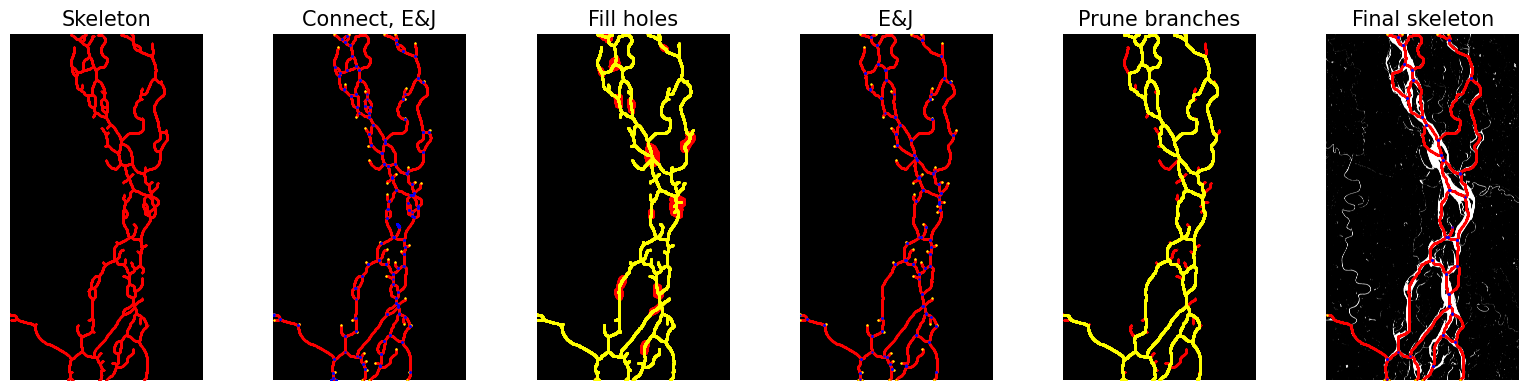

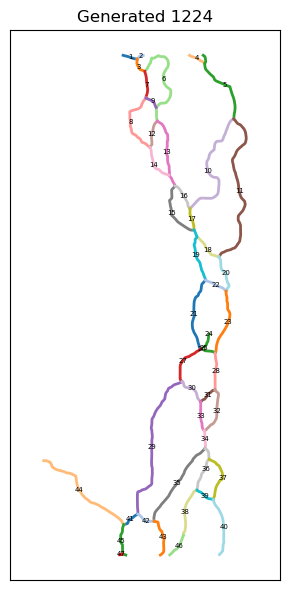

SUCCESSFUL SKELETON! Saving files...
Runnning braided river analysis for: 20241121
Closest mask date: 1124
Proceed with operation skeleton...
...........Running get skeleton algorithm...........
...........Running branch pruning algorithm...........
Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!
...........Running skeleton labeling algorithm...........
...........Running centerline extraction from skeleton algorithm...........
Branch No. 28, less than 2! Skeletonize...
Branch No. 31, less than 2! Skeletonize...
Branch No. 43, less than 2! Skeletonize...
Branch No. 50, less than 2! Skeletonize...
Branch No. 64, less than 2! Skeletonize...
Reprojecting to UTM for better plotting.


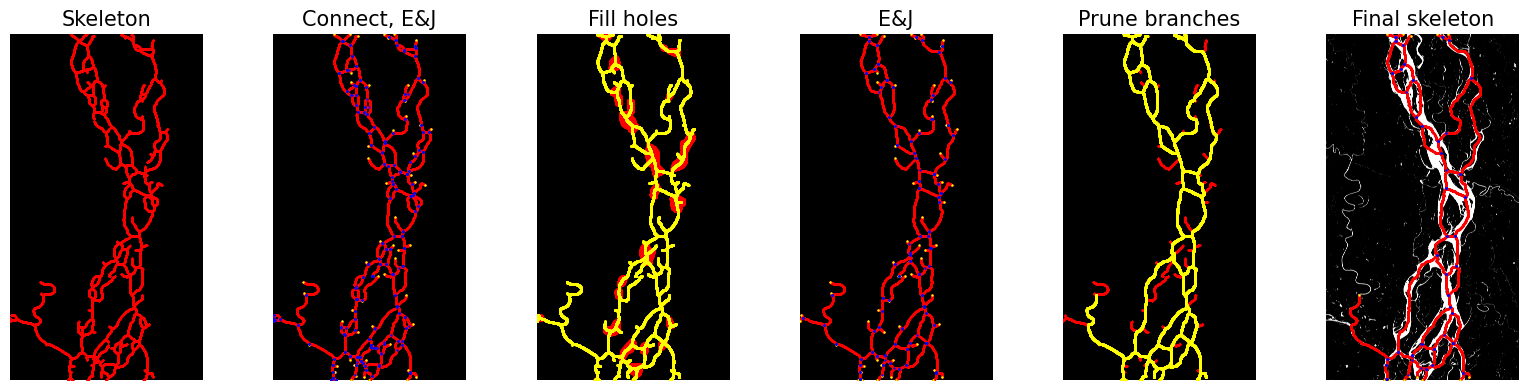

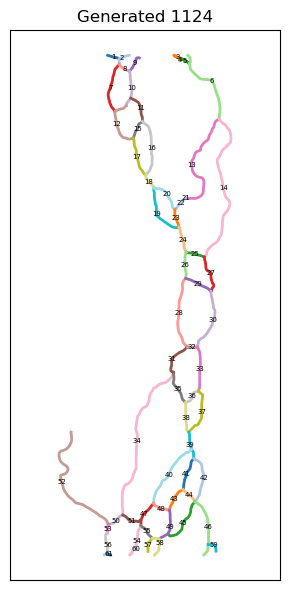

SUCCESSFUL SKELETON! Saving files...
Runnning braided river analysis for: 20241031
Closest mask date: 1024
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20231202
Closest mask date: 1223
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20231111
Closest mask date: 1123
Proceed with operation skeleton...
...........Running get skeleton algorithm...........
...........Running branch pruning algorithm...........
Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!
...........Running skeleton labeling algorithm...........
...........Running centerline extraction from skeleton algorithm...........
Branch No. 4, less than 2! Skeletonize...
Branch No. 39, less than 2! Skeletonize...
Branch No. 57, less than 2! Skeletonize...
Branch No. 60, less than 2! Skeletonize...
Reprojecting to UTM for better plotting.


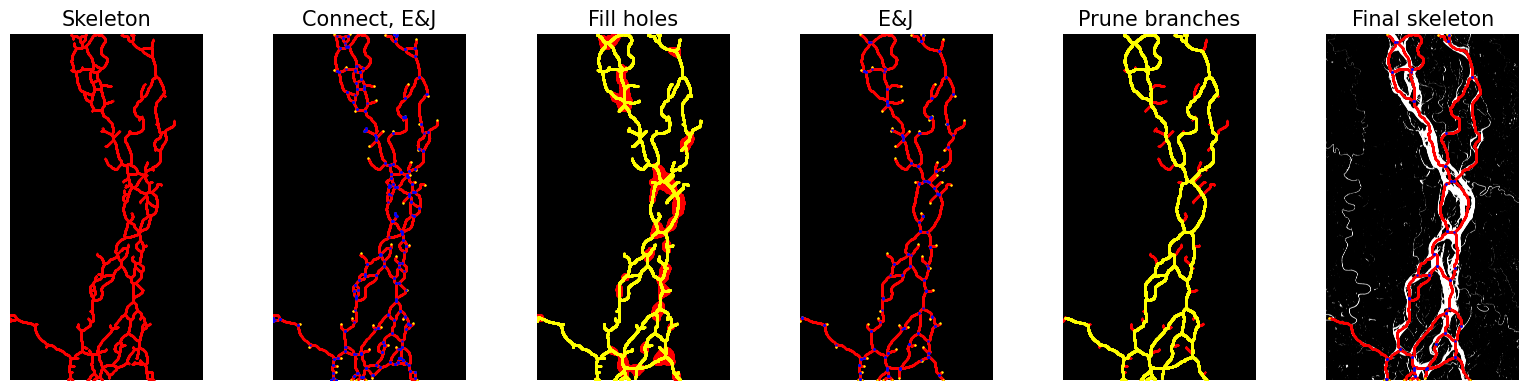

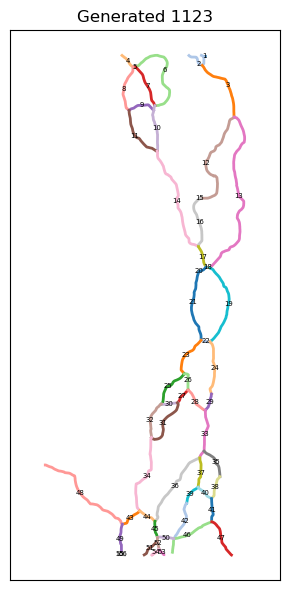

SUCCESSFUL SKELETON! Saving files...
Runnning braided river analysis for: 20231021
Closest mask date: 1023
Proceed with operation skeleton...
...........Running get skeleton algorithm...........
...........Running branch pruning algorithm...........
Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!
...........Running skeleton labeling algorithm...........
...........Running centerline extraction from skeleton algorithm...........
Branch No. 14, less than 2! Skeletonize...
Branch No. 21, less than 2! Skeletonize...
Branch No. 22, less than 2! Skeletonize...
Branch No. 25, less than 2! Skeletonize...
Branch No. 27, less than 2! Skeletonize...
Branch No. 44, less than 2! Skeletonize...
Branch No. 44, still less than two endpoints after skeletonization...try alternate route.


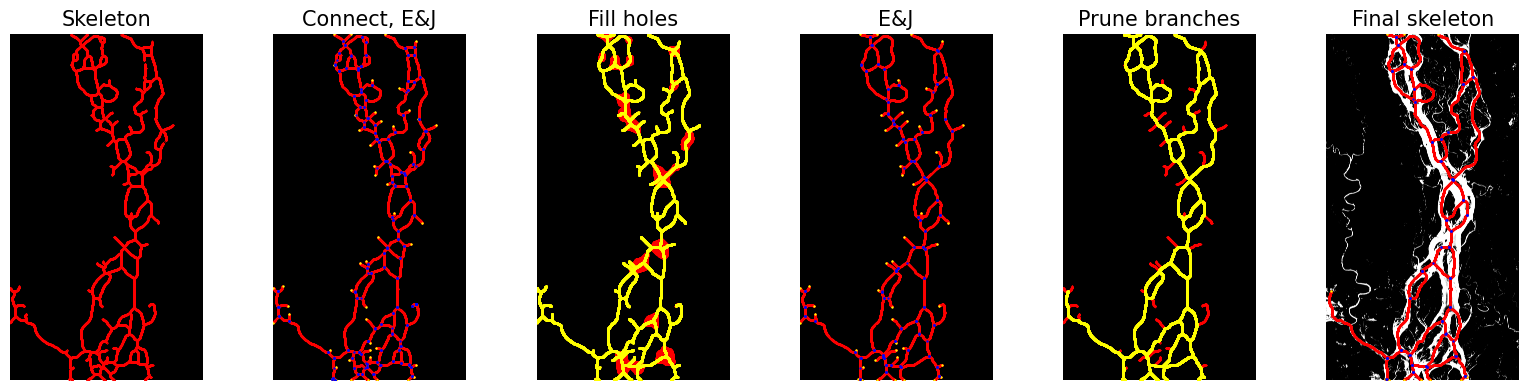

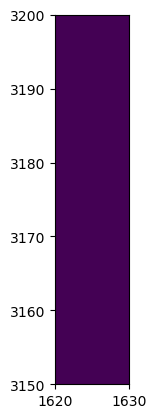

Number of endpoints:  2
Reprojecting to UTM for better plotting.


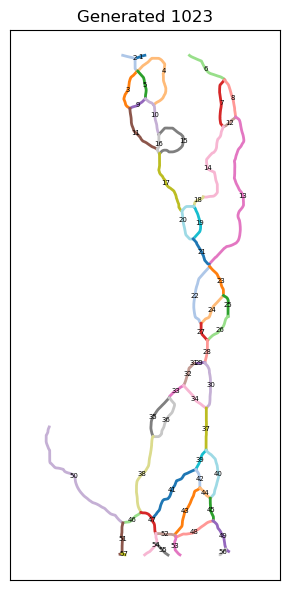

SUCCESSFUL SKELETON! Saving files...
Runnning braided river analysis for: 20231001
Closest mask date: 1023
Proceed with operation skeleton...
Mask centerline already processed!
Runnning braided river analysis for: 20230910
Closest mask date: 0923
Proceed with operation skeleton...
...........Running get skeleton algorithm...........
...........Running branch pruning algorithm...........
Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!
...........Running skeleton labeling algorithm...........
...........Running centerline extraction from skeleton algorithm...........
Branch No. 13, less than 2! Skeletonize...
Branch No. 22, less than 2! Skeletonize...
Branch No. 25, less than 2! Skeletonize...
Branch No. 43, less than 2! Skeletonize...
Branch No. 57, less than 2! Skeletonize...
Reprojecting to UTM for better plotting.


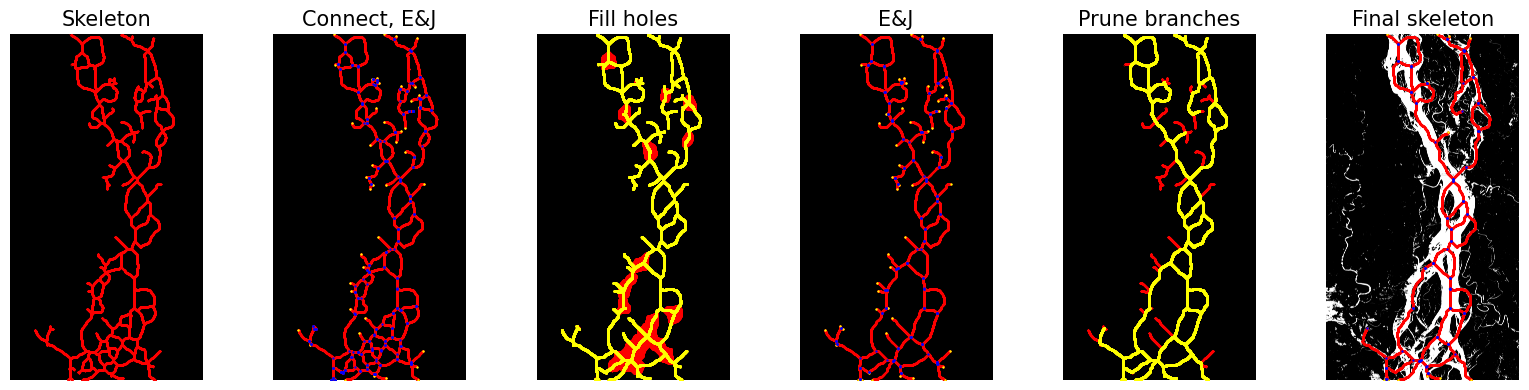

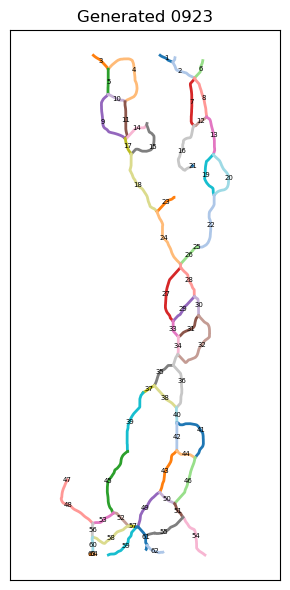

SUCCESSFUL SKELETON! Saving files...
Runnning braided river analysis for: 20230730
Closest mask date: 0623
Proceed with operation skeleton...
...........Running get skeleton algorithm...........
...........Running branch pruning algorithm...........
Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!
...........Running skeleton labeling algorithm...........
...........Running centerline extraction from skeleton algorithm...........
Branch No. 34, less than 2! Skeletonize...
Branch No. 53, less than 2! Skeletonize...
Reprojecting to UTM for better plotting.


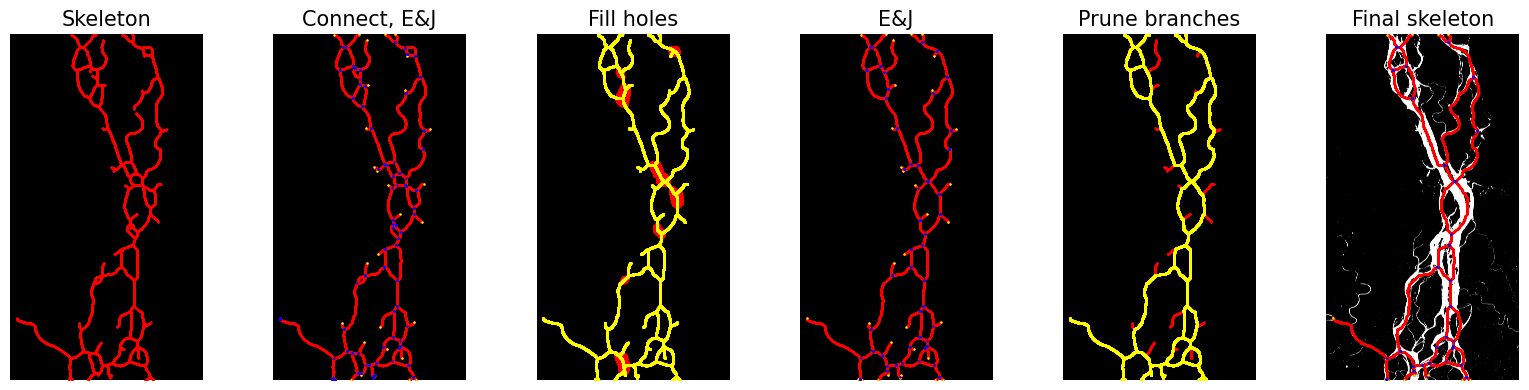

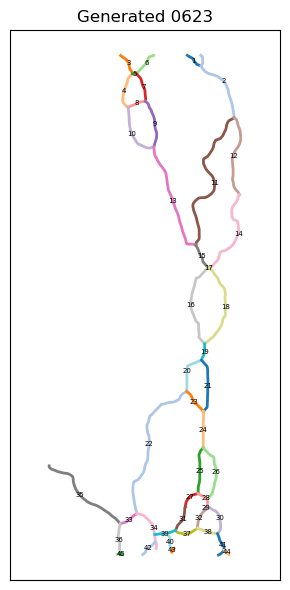

SUCCESSFUL SKELETON! Saving files...


In [8]:
# ------------------------------ DYNAMICS ------------------------------


for filename in pixc_filenames:

    pixcdate = os.path.basename(filename)[29:37]
    print('Runnning braided river analysis for:',str(pixcdate))

    maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)

    # Get season
    if int(maskdate[0:2]) in LFmonths:
        dilate = 10
        gauss = 20
    else:
        dilate = 10
        gauss = 30

    # Proceed with operation skeleton
    print('Proceed with operation skeleton...')
    # Create folder to save files...

    isExist = os.path.exists(odir+tileID)
    if not isExist:
        os.makedirs(odir+tileID)

    tile_figdir = figdir+'/'+tileID+'/'
        
    isExist = os.path.exists(tile_figdir)
    if not isExist:
        os.makedirs(tile_figdir)

    # FIRST Check if a centerline has already been created for this mask....
    if os.path.exists(odir+tileID+'/'+maskdate+'_generated_cl.geojson') and runNewCL == False:
        print('Mask centerline already processed!')
        cl_merged = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
    else:
        water_mask = skel.get_watermask(water_mask_tiff)
        skeleton = skel.get_skeleton(water_mask,pixcdate,tile_figdir,dilate,gauss,savePlot=True)
        pruned_skeleton = skel.get_pruned_skeleton(skeleton, water_mask, pixcdate,tile_figdir,distance_threshold=100,max_hole_size=300,prunethresh=600) # distance thresh for connecting pixels
        labeled_skeleton = skel.get_labeled_skeleton(pruned_skeleton,pixcdate,tile_figdir,savePlot=True)
        gen_cl = skel.extract_cl_from_skeleton(labeled_skeleton,water_mask_tiff)
        cl_merged = skel.merge_short_centerlines(gen_cl,hemi)
        skel.plot_merged(cl_merged,maskdate,tile_figdir)
        
        print('SUCCESSFUL SKELETON! Saving files...')
        cl_merged.to_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')




In [10]:
# ------------------------------ plotting generated centerlines colored by unique label ------------------------------


runNewCL = False


for filename in pixc_filenames:

    pixcdate = os.path.basename(filename)[29:37]
    print('Runnning braided river analysis for:',str(pixcdate))

    maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)
    print('Closest mask date:',str(maskdate))
    # Get season
    if int(maskdate[0:2]) in LFmonths:
        dilate = 10
        gauss = 20
    else:
        dilate = 10
        gauss = 30

    # Proceed with operation skeleton
    print('Proceed with operation skeleton...')
    # Create folder to save files...

    isExist = os.path.exists(odir+tileID)
    if not isExist:
        os.makedirs(odir+tileID)

    tile_figdir = figdir+'/'+tileID+'/'
        
    isExist = os.path.exists(tile_figdir)
    if not isExist:
        os.makedirs(tile_figdir)

    # FIRST Check if a centerline has already been created for this mask....
    if os.path.exists(odir+tileID+'/'+maskdate+'_generated_cl.geojson') and runNewCL == False:
        print('Mask centerline already processed!')
        cl_merged = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
        plot_merged(cl_merged,maskdate,tile_figdir)
    # else:
        # water_mask = skel.get_watermask(water_mask_tiff)
        # skeleton = skel.get_skeleton(water_mask,pixcdate,tile_figdir,dilate,gauss,savePlot=True)
        # pruned_skeleton = skel.get_pruned_skeleton(skeleton, water_mask, pixcdate,tile_figdir,distance_threshold=100,max_hole_size=300,prunethresh=600) # distance thresh for connecting pixels
        # labeled_skeleton = skel.get_labeled_skeleton(pruned_skeleton,pixcdate,tile_figdir,savePlot=True)
        # gen_cl = skel.extract_cl_from_skeleton(labeled_skeleton,water_mask_tiff)
        # cl_merged = skel.merge_short_centerlines(gen_cl,hemi)
        # skel.plot_merged(cl_merged,maskdate,tile_figdir)
        
        # print('SUCCESSFUL SKELETON! Saving files...')
        # cl_merged.to_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
        # #cl_merged.to_file(odir+maskdate+'_generated_cl.geojson')



'/Volumes/OneTouch/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_1123.tif'

In [ ]:
# ---------------------------- Testing one: do the selected channels (and their processing) work out? ----------------------------


# '0524':['2','5','7','8','9','12','14','16','19','23','25'],

channel1_dict = dict({'0124':['2','3','5','7','8','11','13','15','17','19'],
                      '0224':['2','3','6','10','11','12','15','17','19','20','22','24'],
                      '0324':['1','3','5','10','11','12','14','17','19','20','22','24'],
                      '0424':['1','2','4','9','10','11','14','15','17','19','23','26'],
                      '0524':['2','6','8','9','10','11','14','16','18','21','25','27'],
                      '0924':['3','5','6','7','10','13','15','18','22','28'],
                      '1024':['3','5','6','7','8','11','14','17','20','24'],
                      '1223':['3','4','7','10','11','12','15','16','19','23','26']})
channel2_dict = dict({'0124':['10','12','21','22','25','26','27'],
                      '0224':['14','16','26','27','30','31','32'],
                      '0324':['15','16','26','27','30','31','32','33'],
                      '0424':['13','16','24','28','29','32','34','35','36'],
                      '0524':['13','17','30','29','31','35','37','38','40','42'],
                      '0924':['11','14','24','25','31','33','35'],
                      '1024':['10','12','15','22','27','30','31','34','36'],
                      '1223':['14','24','28','29','32','34','35','37','38']})

pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*") # Need to download 1 year of data for this tile! 
pixc_filenames

filename = '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc'
maskdate = '0524'

cl_gen = gpd.read_file(odir+maskdate+'_generated_cl.geojson')
cl_gen = cl_gen.to_crs('EPSG:4326') 
sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

# Plot generated CL with SWORD cl
fig, ax = plt.subplots(figsize=(3, 6))
for _, row in cl_gen.iterrows():
    ax.plot(*row.geometry.xy, color='blue', linewidth=2)

for _, row in sword_cl_gdf.iterrows():
    ax.plot(*row.geometry.xy, color='yellow', linewidth=2)

ax.plot(sword_cline.xy, color='yellow', linewidth=2)

# Set plot properties
ax.set_title("Generated "+str(maskdate))
ax.axis("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(89.575,89.855)
ax.set_ylim(23.8,24.55)

plt.tight_layout()
plt.savefig(figdir+'/'+maskdate+'_generated_centerlines_unlabeled.png')
plt.show()

# # Plot also the water mask for comparison
# fig, ax = plt.subplots(figsize=(3, 6))
# ax.imshow(water_mask, cmap=plt.cm.gray)
# ax.axis('off')
# ax.set_title('Water mask '+str(maskdate))

# plt.tight_layout()
# plt.savefig(figdir+'/'+maskdate+'_watermask.png')
# plt.show()

# Read in SWOT data
# print('Reading in SWOT PIXC data....')
# swot_pixc = gpd.read_file(odir+pixcdate+'_pixc_gdf_wChannels.geojson')

ch1 = channel1_dict[maskdate]
ch2 = channel2_dict[maskdate]

ch1 = list(map(int, ch1))
ch2 = list(map(int, ch2))

branch_colors = ['green','blue']

## ------------------- Extract centerlines for joint branches and project SWOT pixc data 
for i in range(2):
    if i == 0:
        selChannels_list = ch1
    if i == 1:
        selChannels_list = ch2

    selChannels = selChannels_list #list(map(int, selChannels_list))

    print('Extracting centerline from cl gdf... (merging and sorting) for channel:',i+1)
    # get connected CL
    idb = cl_gen['branch_id'].isin(selChannels_list)
    sel_cl = cl_gen.loc[idb]
    #sel_cl.plot()
    sel_cl = sel_cl.reset_index(drop=True)

    # # Fill any gaps in selected centerline and sort reaches
    merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts

    # Merge the MultiLineString into a single LineString
    merged_line = skel.merge_multiline_with_gaps(merged_parts) # turns final multilinestring into linestring and bridges any large gaps between parts

    merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)
    merged_line_gdf.plot()
    print(merged_line_gdf)
    print(type(merged_line_gdf))


    # sorted_gdf, line_sorted = sort_general_cl(merged_line_gdf,showPlots=True,reverse=True) # Does this need to be a single line?

    # sorted_gdf.plot()


    # print('Projecting SWOT PIXC to joint centerline...')
    # # Select all PIXC data associated with these channels and plot projected to CL
    # idx = swot_pixc['channelID'].isin(selChannels_list)
    # swot_pixc.loc[idx, 'joint_channel_id'] = i + 1

    # swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(sorted_gdf,swot_pixc.loc[idx,['geometry']],hemi)
    # print('Projected!')


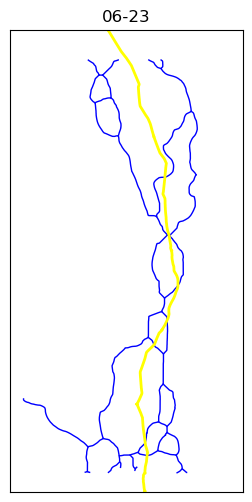

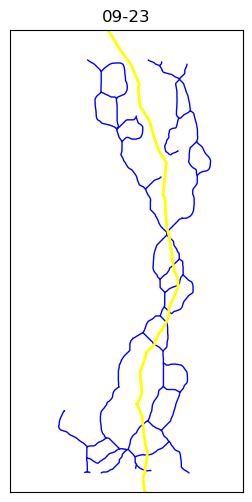

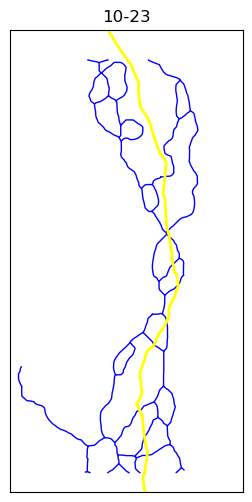

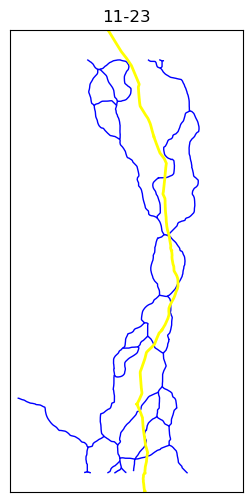

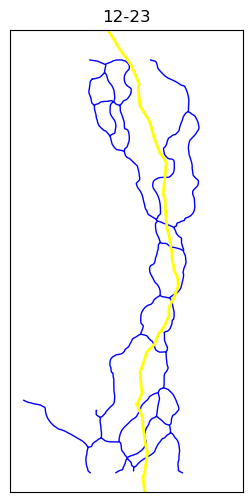

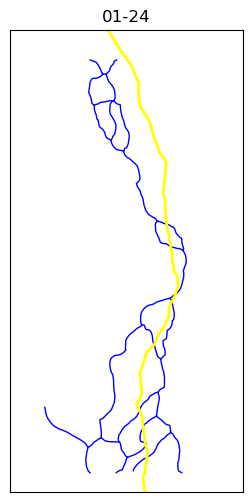

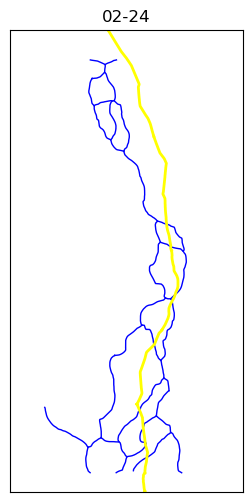

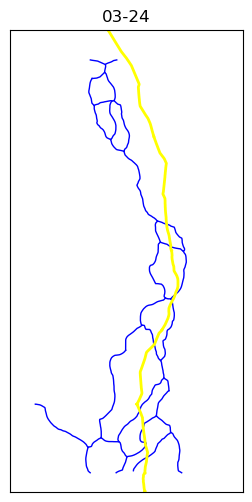

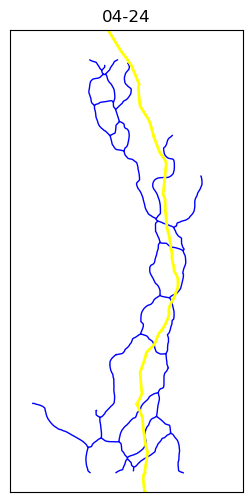

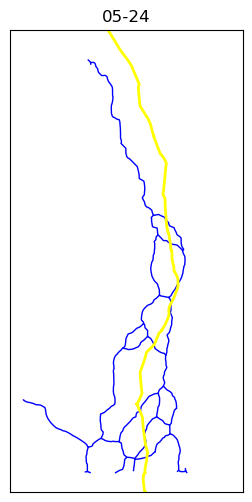

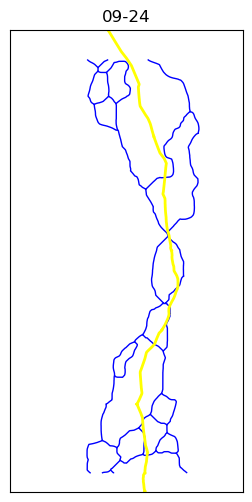

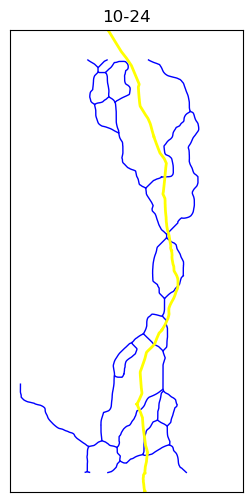

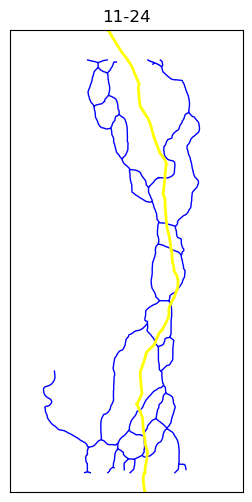

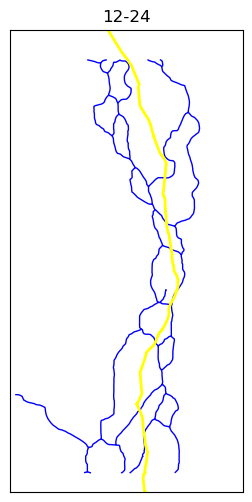

In [8]:
# ------------------------------ plotting generated centerline and watermask images (side by side and one on top of another) ------------------------------


# Get list of all mask dates
maskdates = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/"+tileID+"/S2_WaterMask_NDWI_****.tif")
maskdates = [os.path.basename(mask)[18:22] for mask in maskdates]
maskdates_list = [ date for date in maskdates if date.isnumeric() ]
sorted_dates = sorted(maskdates_list, key=lambda x: (int(x[2:]), int(x[:2])))

# Find mask date
for maskdate in sorted_dates:

    water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/"+tileID+"/S2*"+str(maskdate)+".tif")
    

    water_mask_tiff = water_mask_tiff[0]

    #water_mask = skel.get_watermask(water_mask_tiff)

    if not glob.glob(odir+tileID+'/'+maskdate+'_generated_cl.geojson'):
        # Check if a centerline was created for this mask
        continue

    cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
    cl_gen = cl_gen.to_crs('EPSG:4326') 
    sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

    isExist = os.path.exists(figdir+'/'+tileID+'/')
    if not isExist:
        os.makedirs(figdir+'/'+tileID+'/')

    # Plot generated CL
    fig, ax = plt.subplots(figsize=(3, 6))

    for _, row in cl_gen.iterrows():
        ax.plot(*row.geometry.xy, color='blue', linewidth=1)

    # PLOT SWORD CL on top
    for _, row in sword_cl_gdf.iterrows():
        ax.plot(*row.geometry.xy, color='yellow', linewidth=2)

   # ax.plot(sword_cline.xy, color='yellow', linewidth=2)
    # Set plot properties
    ax.set_title(str(maskdate[0:2]+'-'+str(maskdate[2:4])))
    ax.axis("equal")
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlim(89.575,89.855)
    ax.set_ylim(24.0,24.7)
    plt.savefig(figdir+'/'+tileID+'/'+maskdate+'_generated_cl.png')

    plt.show()

    # # Plot watermask
    # water_mask = skel.get_watermask(water_mask_tiff)
    # fig, ax = plt.subplots(figsize=(3, 6))
    # ax.imshow(water_mask, cmap=plt.cm.gray)
    # ax.axis('off')
    # ax.set_title(str(maskdate[0:2]+'-'+str(maskdate[2:4])))
    # plt.savefig(figdir+'/'+tileID+'/'+maskdate+'_mask.png')
    # plt.tight_layout()
    # plt.show()

    # # PLOT mask and centerline
    # fig, ax = plt.subplots(figsize=(3, 6))
    # coords_df = cl_gen.get_coordinates()
    # cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
    # ax.imshow(water_mask, cmap=plt.cm.gray)
    # ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.05)
    # ax.axis('off')
    # ax.set_title(str(maskdate[0:2]+'-'+str(maskdate[2:4])))

    # plt.tight_layout()
    # plt.savefig(figdir+'/'+tileID+'/'+maskdate+'_generated_cl_wMask.png')
    # plt.show()



In [ ]:
### code below this is was used to look at individual slopes of two channels over time

Runnning slope analysis for: 20240517
Closest mask date: 0524


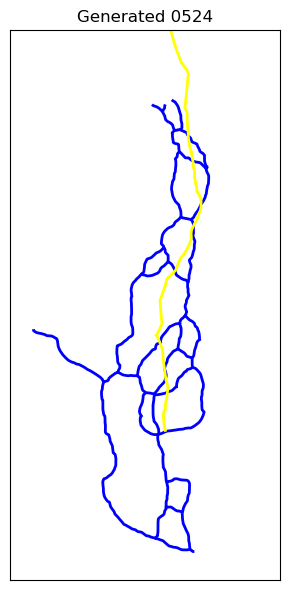

Reading in SWOT PIXC data....
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Slope negative! Flipping centerline and re-projecting...
Projected!
CH. 1 slope = 4.2428 cm/km
CH. 2 slope = 6.2672 cm/km


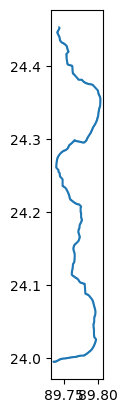

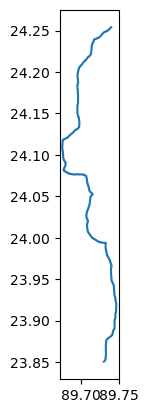

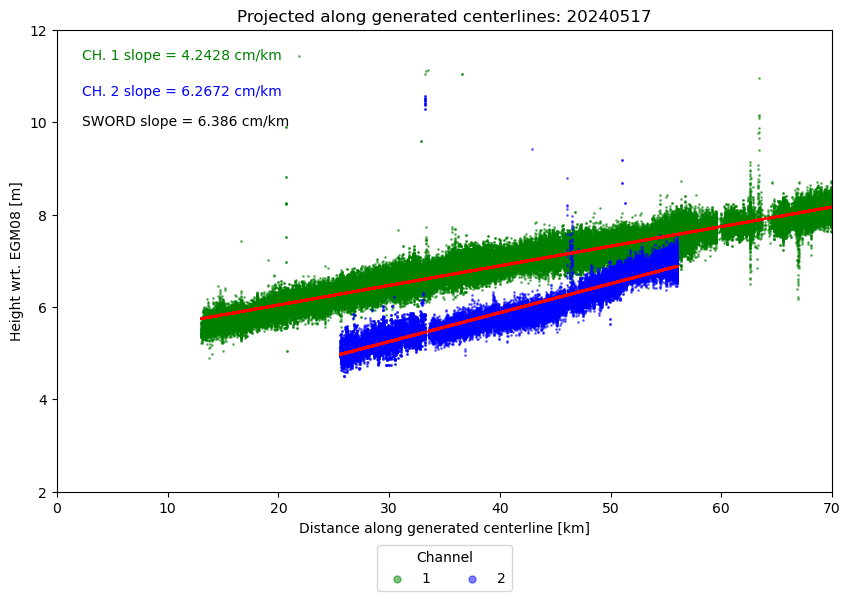

CH. 1 slope = 5.5851 cm/km
CH. 2 slope = 8.4427 cm/km


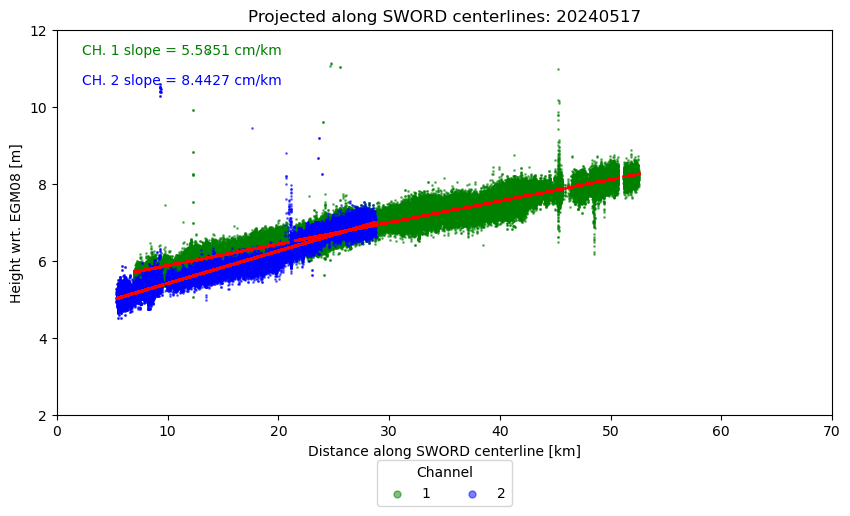

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


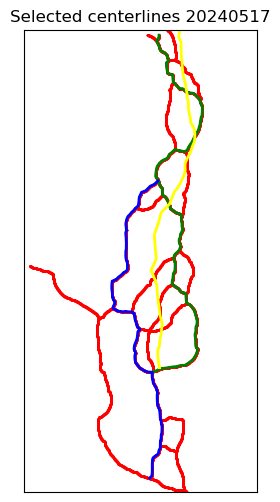

Runnning slope analysis for: 20240426
Closest mask date: 0424


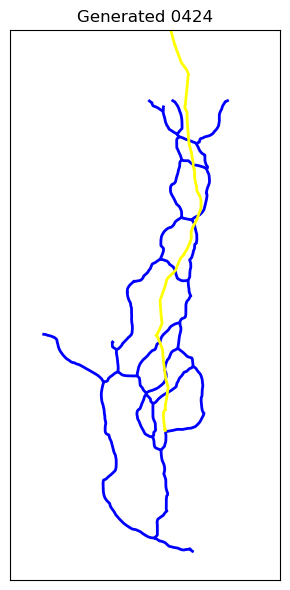

Reading in SWOT PIXC data....
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Slope negative! Flipping centerline and re-projecting...
Projected!
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
CH. 1 slope = 3.7894 cm/km
CH. 2 slope = 5.944 cm/km


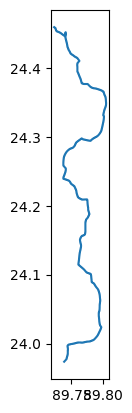

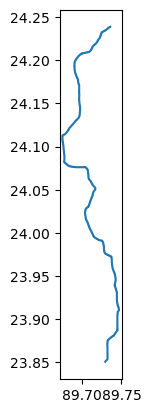

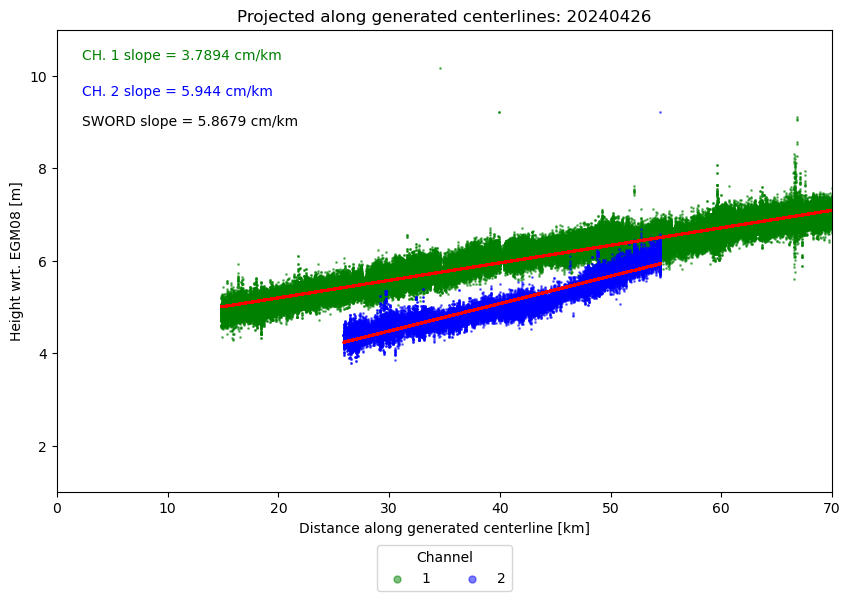

CH. 1 slope = 5.2343 cm/km
CH. 2 slope = 8.0508 cm/km


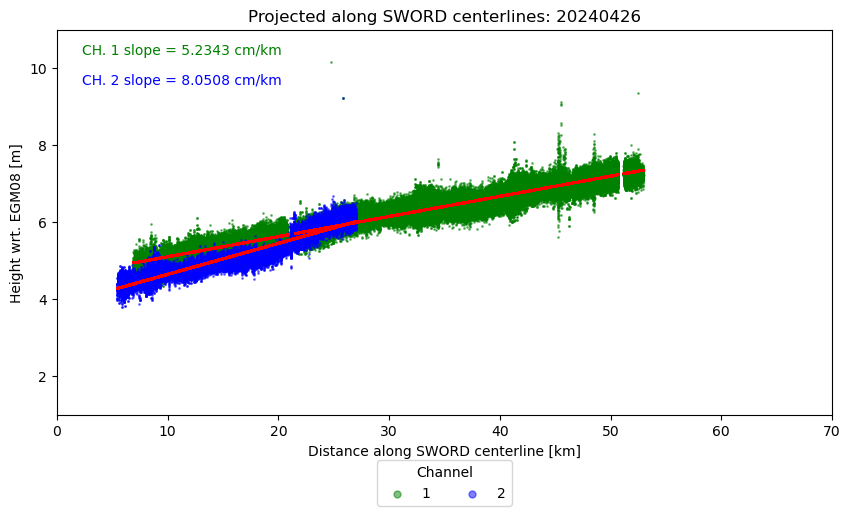

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


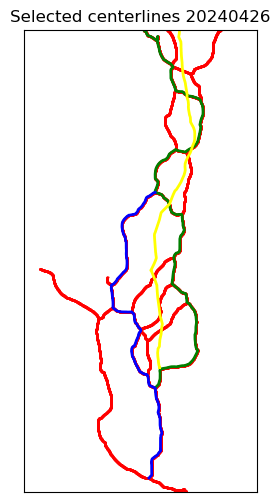

Runnning slope analysis for: 20240405
Closest mask date: 0424


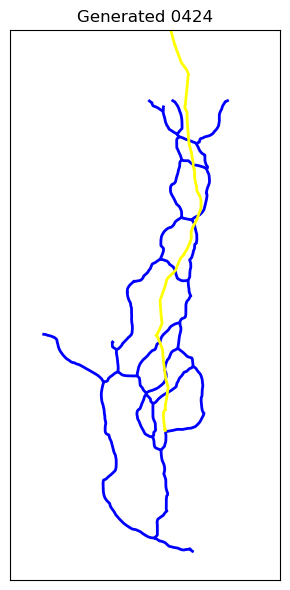

Reading in SWOT PIXC data....
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Slope negative! Flipping centerline and re-projecting...
Projected!
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
CH. 1 slope = 3.5539 cm/km
CH. 2 slope = 5.8081 cm/km


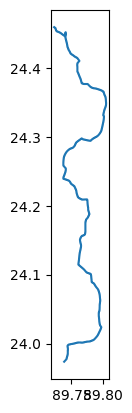

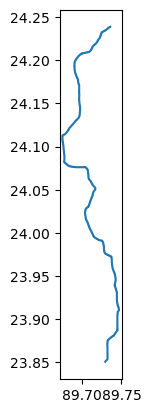

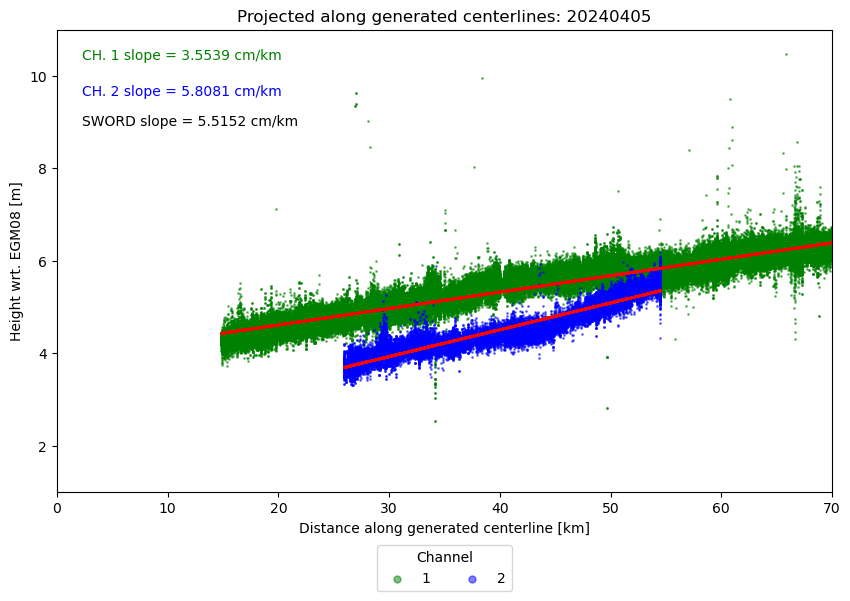

CH. 1 slope = 4.9034 cm/km
CH. 2 slope = 7.8412 cm/km


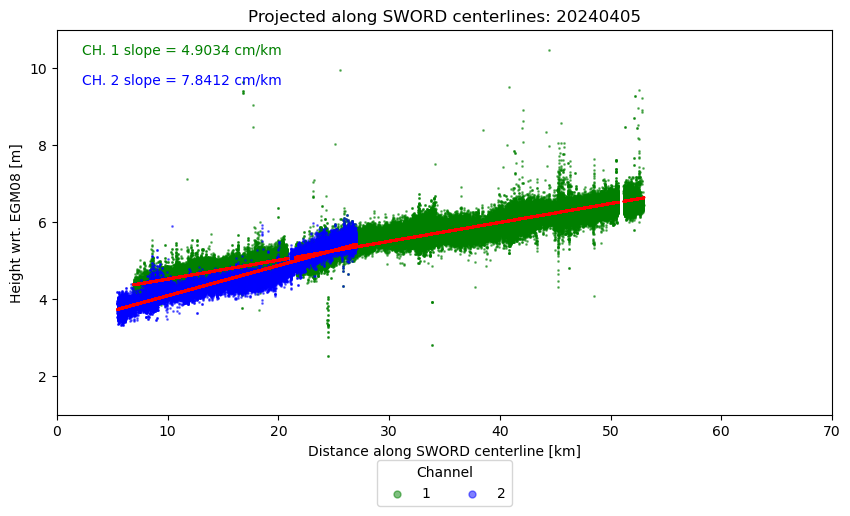

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


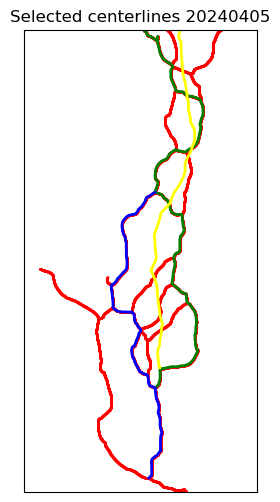

Runnning slope analysis for: 20240315
Closest mask date: 0324


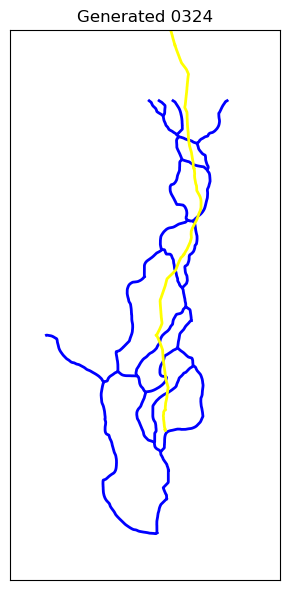

Reading in SWOT PIXC data....
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Slope negative! Flipping centerline and re-projecting...
Projected!
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
CH. 1 slope = 3.1394 cm/km
CH. 2 slope = 4.5394 cm/km


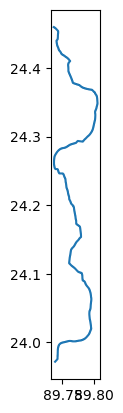

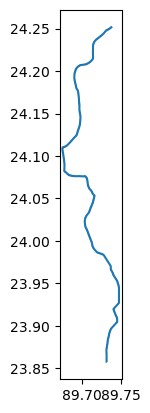

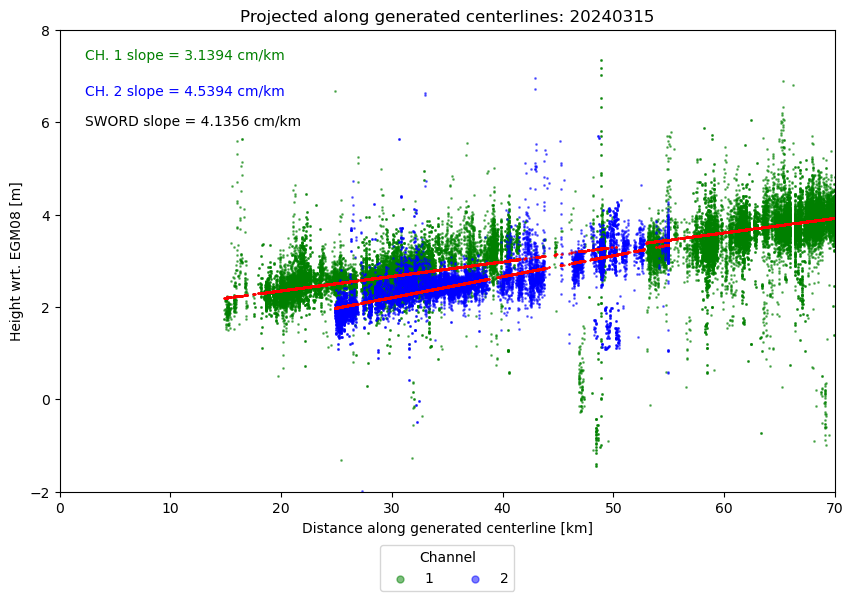

CH. 1 slope = 4.2082 cm/km
CH. 2 slope = 6.1497 cm/km


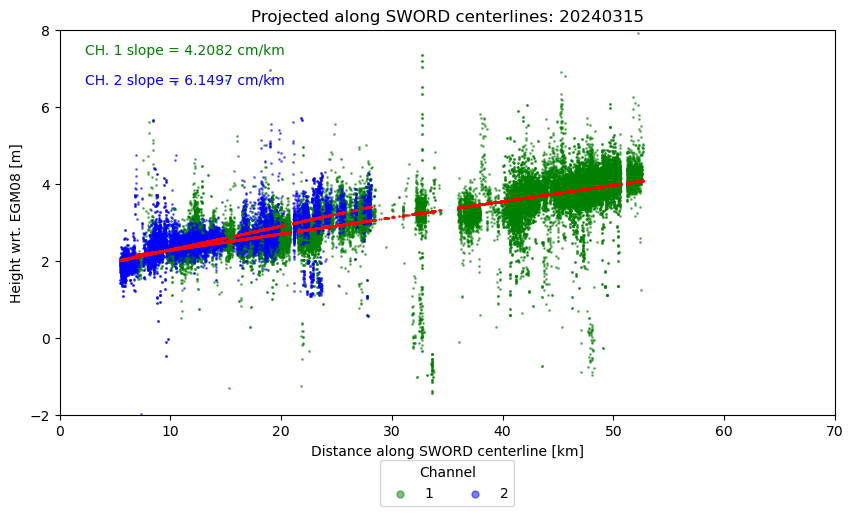

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


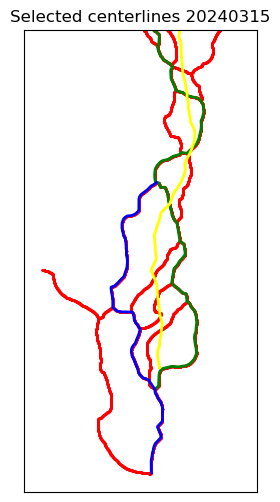

Runnning slope analysis for: 20240224
Closest mask date: 0224


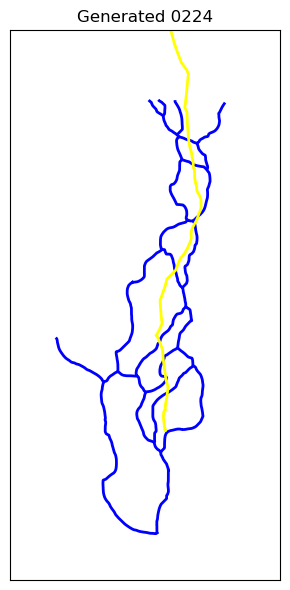

Reading in SWOT PIXC data....
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
CH. 1 slope = 3.5378 cm/km
CH. 2 slope = 5.887 cm/km


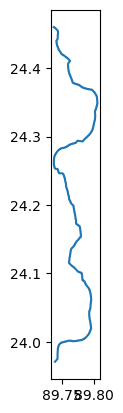

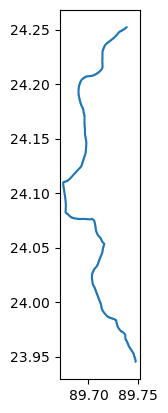

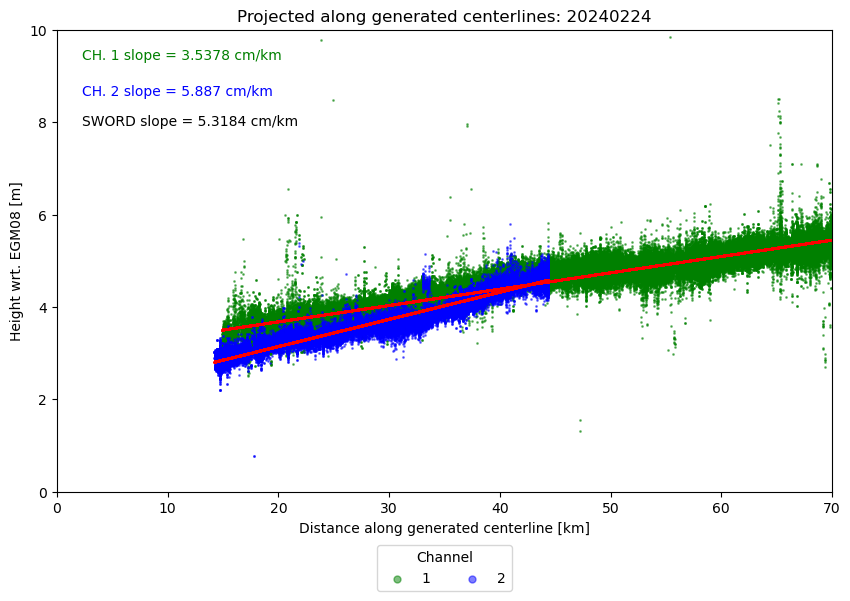

CH. 1 slope = 4.7183 cm/km
CH. 2 slope = 7.8993 cm/km


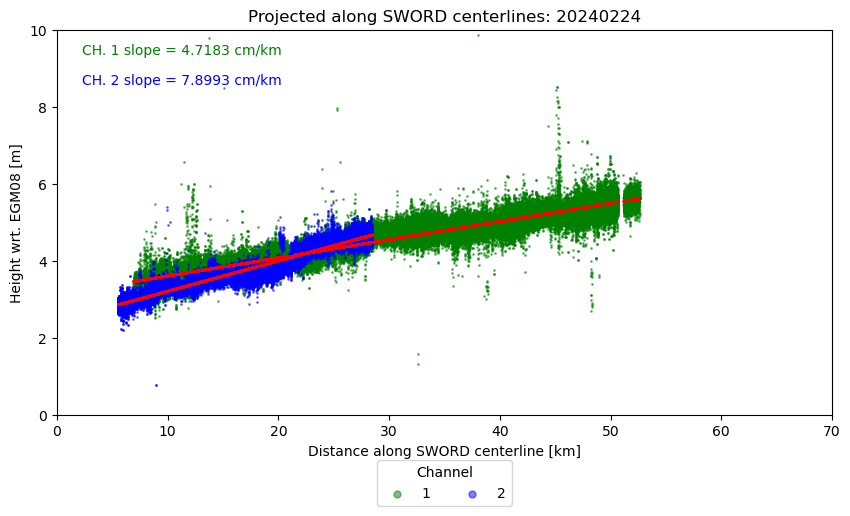

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


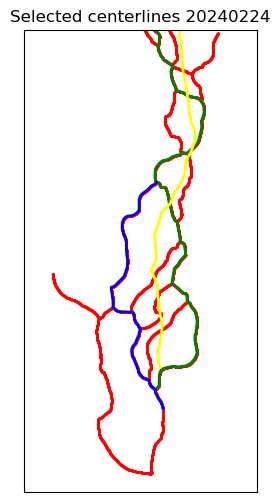

Runnning slope analysis for: 20240113
Closest mask date: 0124


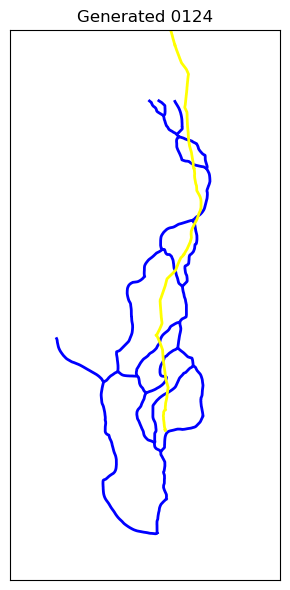

Reading in SWOT PIXC data....
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
CH. 1 slope = 3.6442 cm/km
CH. 2 slope = 6.0052 cm/km


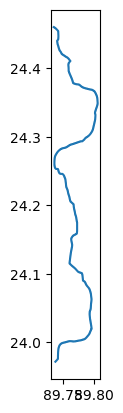

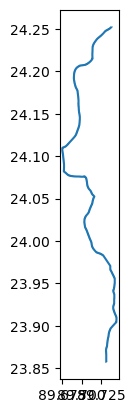

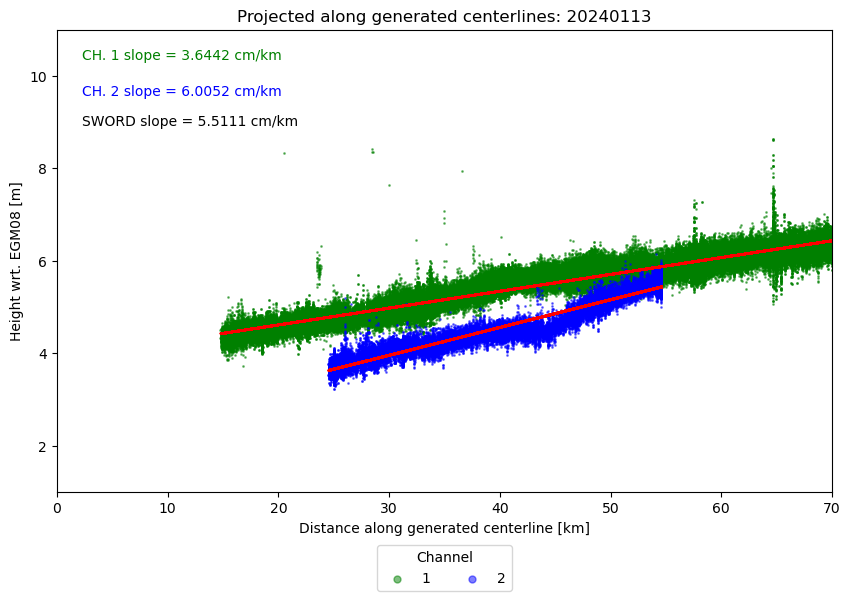

CH. 1 slope = 4.8036 cm/km
CH. 2 slope = 8.0689 cm/km


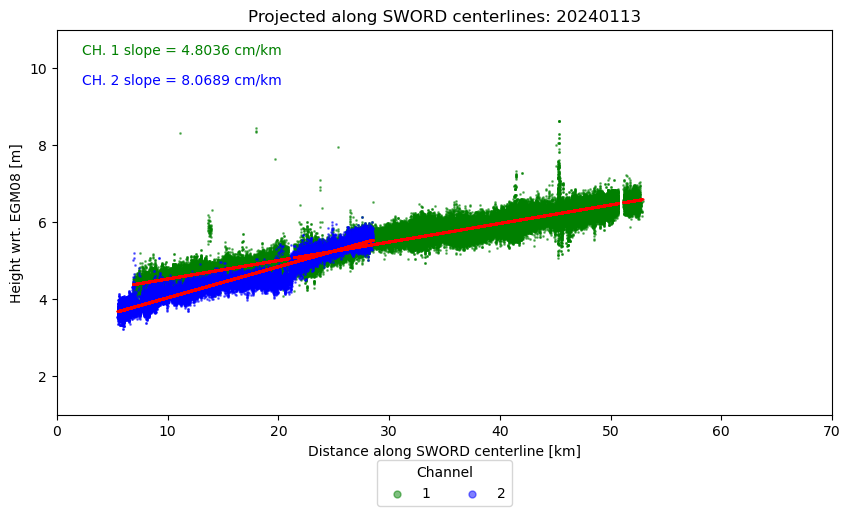

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


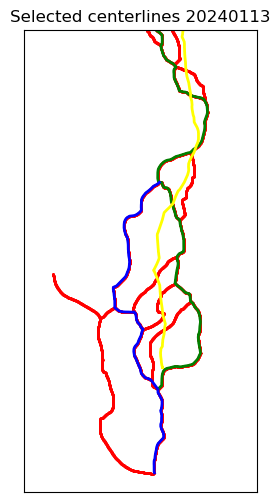

Runnning slope analysis for: 20231202
Closest mask date: 1223


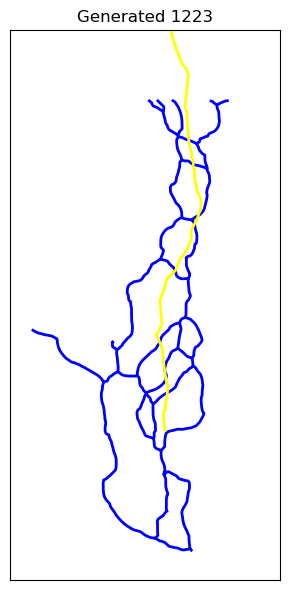

Reading in SWOT PIXC data....
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Checking slope...
CH. 1 slope = 3.349 cm/km
CH. 2 slope = 5.1678 cm/km


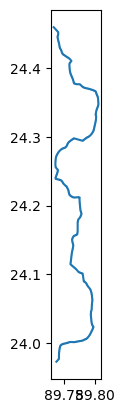

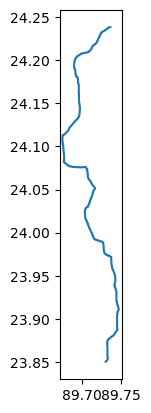

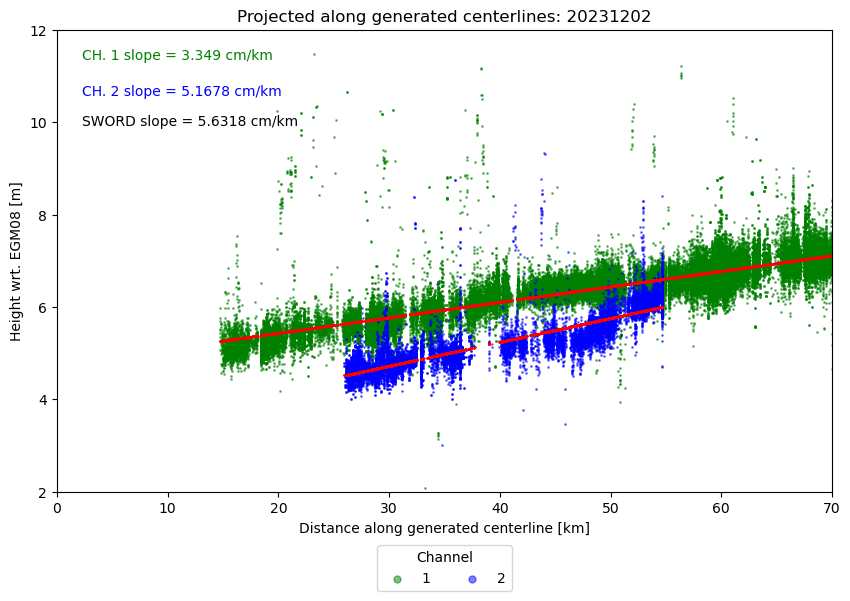

CH. 1 slope = 4.6194 cm/km
CH. 2 slope = 7.1373 cm/km


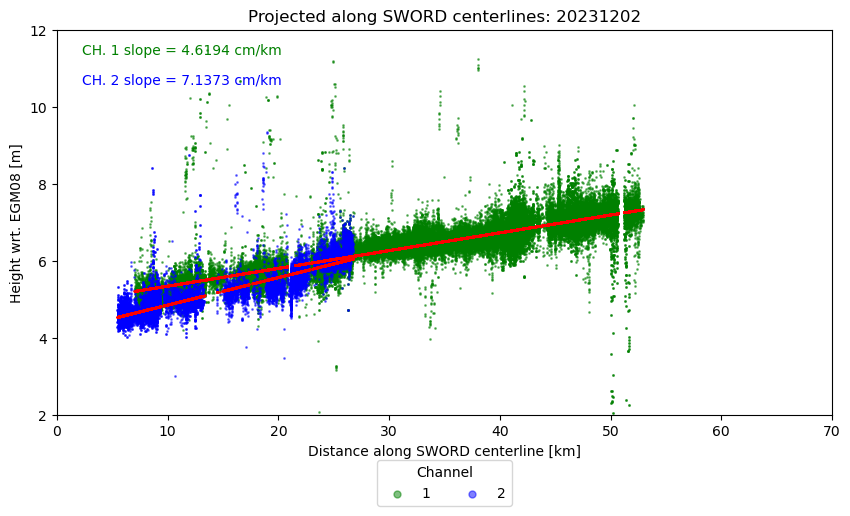

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


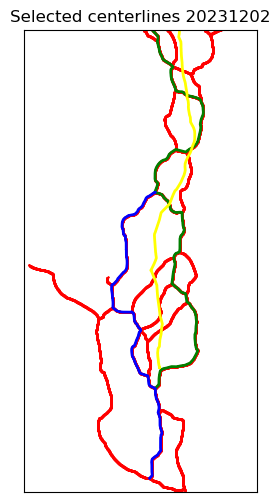

In [ ]:
### ---------------------------- Now, load in all centerlines and save individual images of 1. generated centerlines with and without label (same fig view), 2. SWOT projection onto new joint centerline, slope computed
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*") # Need to download 1 year of data for this tile! 

pixc_filenames = ['/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_018_258_112L_20240719T030033_20240719T030044_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_021_258_112L_20240919T171548_20240919T171559_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_020_258_112L_20240829T203042_20240829T203053_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_019_258_112L_20240808T234537_20240808T234548_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_017_258_112L_20240628T061528_20240628T061539_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_015_258_112L_20240517T124519_20240517T124530_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_014_258_112L_20240426T160014_20240426T160025_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_013_258_112L_20240405T191508_20240405T191519_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_012_258_112L_20240315T223004_20240315T223015_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_011_258_112L_20240224T014502_20240224T014513_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_009_258_112L_20240113T081450_20240113T081501_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_007_258_112L_20231202T144441_20231202T144452_PIC0_01.nc']
# Need to do still:  
pixc_filenames = [
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_015_258_112L_20240517T124519_20240517T124530_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_014_258_112L_20240426T160014_20240426T160025_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_013_258_112L_20240405T191508_20240405T191519_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_012_258_112L_20240315T223004_20240315T223015_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_011_258_112L_20240224T014502_20240224T014513_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_009_258_112L_20240113T081450_20240113T081501_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_007_258_112L_20231202T144441_20231202T144452_PIC0_01.nc']

# pixc_filenames = [
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_012_258_112L_20240315T223004_20240315T223015_PIC0_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_011_258_112L_20240224T014502_20240224T014513_PIC0_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_009_258_112L_20240113T081450_20240113T081501_PIC0_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_007_258_112L_20231202T144441_20231202T144452_PIC0_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_018_258_112L_20240719T030033_20240719T030044_PIC0_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc']



LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

# Pre-selected channels
channel1_dict = dict({'0124':['2','3','5','7','8','11','13','15','17','19'],
                      '0224':['2','3','6','10','11','12','16','19','21','22','24','26'], # this one may need ch 13
                      '0324':['1','3','5','10','11','12','15','18','20','21','23','25'], # this one may need ch 13
                      '0424':['1','2','4','9','10','11','12','15','16','18','20','24','27'],
                      '0524':['2','6','8','9','10','11','14','16','18','21','25','27'], # large gap
                      '0924':['3','5','6','7','10','13','15','18','22','28'],
                      '1024':['3','5','6','7','8','11','14','17','20','24'],
                      '1223':['4','5','8','11','12','13','16','17','20','24','27']}) # large gap
channel2_dict = dict({'0124':['10','12','21','22','25','26','27'], # large gap
                      '0224':['15','18','28','29','32','33','32'],
                      '0324':['16','17','27','28','31','32','33','34'], # large gap
                      '0424':['14','17','25','29','30','33','35','36','37'],
                      '0524':['13','17','30','29','31','35','37','38','40','42'],
                      '0924':['11','14','24','25','31','33','35'],
                      '1024':['10','12','15','22','27','30','31','34','36'],
                      '1223':['15','25','29','30','33','35','36','38','39']})


# Load in centerlines
for filename in pixc_filenames:

    pixcdate = os.path.basename(filename)[29:37]
    print('Runnning slope analysis for:',str(pixcdate))

    # Find mask date
    maskdate = pixcdate[4:6]+pixcdate[2:4]
    water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")

     # Need to find next closest mask in the same season...
    if not water_mask_tiff:
        currentmonth = pixcdate[4:6]
        if int(currentmonth) in LFmonths:
            season_months = LFmonths
        else:
            season_months = HFmonths


        dist = np.abs(np.array(season_months) - int(currentmonth))
        for j in np.unique(dist):
            if dist[dist == j][0] == 0: # skip if comparing with self
                continue
            if len(dist[dist == j]) > 1:
                # check first closest month
                monthid_indist = np.where(dist == j)[0][0]
                nextmonth = season_months[monthid_indist]
                if nextmonth < 10:
                    nextmonth = '0'+str(nextmonth)
                else:
                    nextmonth = str(nextmonth)

                maskdate = nextmonth+pixcdate[2:4]
                water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
                if water_mask_tiff:
                    break

                # check second closest month
                monthid_indist = np.where(dist == j)[0][1]
                nextmonth = season_months[monthid_indist]
                if nextmonth < 10:
                    nextmonth = '0'+str(nextmonth)
                else:
                    nextmonth = str(nextmonth)

                maskdate = nextmonth+pixcdate[2:4]
                water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
                if water_mask_tiff:
                    break

            else:
                monthid_indist = np.where(dist == j)[0][0]
                nextmonth = season_months[monthid_indist]
                if nextmonth < 10:
                    nextmonth = '0'+str(nextmonth)
                else:
                    nextmonth = str(nextmonth)

                maskdate = nextmonth+pixcdate[2:4]
                water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
                if water_mask_tiff:
                    break

    print('Closest mask date:',str(maskdate))
    water_mask_tiff = water_mask_tiff[0]
    #water_mask = skel.get_watermask(water_mask_tiff)

    cl_gen = gpd.read_file(odir+maskdate+'_generated_cl.geojson')
    cl_gen = cl_gen.to_crs('EPSG:4326') 
    sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

    fig, ax = plt.subplots(figsize=(3, 6))
    for _, row in cl_gen.iterrows():
        ax.plot(*row.geometry.xy, color='blue', linewidth=2)

    for _, row in sword_cl_gdf.iterrows():
        ax.plot(*row.geometry.xy, color='yellow', linewidth=2)

    ax.plot(sword_cline.xy, color='yellow', linewidth=2)

    # Set plot properties
    ax.set_title("Generated "+str(maskdate))
    ax.axis("equal")
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(89.575,89.855)
    ax.set_ylim(23.8,24.55)

    plt.tight_layout()
    plt.savefig(figdir+'/'+maskdate+'_generated_centerlines_unlabeled.png')
    plt.show()

    # # Plot also the water mask for comparison
    # fig, ax = plt.subplots(figsize=(3, 6))
    # ax.imshow(water_mask, cmap=plt.cm.gray)
    # ax.axis('off')
    # ax.set_title('Water mask '+str(maskdate))

    # plt.tight_layout()
    # plt.savefig(figdir+'/'+maskdate+'_watermask.png')
    # plt.show()

    # Read in SWOT data
    print('Reading in SWOT PIXC data....')
    swot_pixc = gpd.read_file(odir+pixcdate+'_pixc_gdf_wChannels.geojson')

    ch1 = channel1_dict[maskdate]
    ch2 = channel2_dict[maskdate]

    ch1 = list(map(int, ch1))
    ch2 = list(map(int, ch2))

    branch_colors = ['green','blue']

    swot_pixc['joint_channel_id'] = 0
    swot_pixc['dist_jointChannel'] = 0

    ## ------------------- Extract centerlines for joint branches and project SWOT pixc data 
    for i in range(2):
        if i == 0:
            selChannels_list = ch1
        if i == 1:
            selChannels_list = ch2

        selChannels = selChannels_list #list(map(int, selChannels_list))

        print('Extracting centerline from cl gdf... (merging and sorting)')
        # get connected CL
        idb = cl_gen['branch_id'].isin(selChannels_list)
        sel_cl = cl_gen.loc[idb]

        # Fill any gaps in selected centerline and sort reaches by branch id
        sel_cl = sel_cl.reset_index(drop=True)
        merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
        if isinstance(merged_parts,LineString):
            merged_line = merged_parts
        else:
            merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

        merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)
        merged_line_gdf.plot()
        sorted_gdf = merged_line_gdf

        # OLD VERSION
        # merged_gdf = fill_cl_gaps(sel_cl,hemi)
        # sorted_gdf, line_sorted = sort_general_cl(merged_gdf,showPlots=False,reverse=True) # Does this need to be a single line?

        print('Projecting SWOT PIXC to joint centerline...')
        # Select all PIXC data associated with these channels and plot projected to CL
        idx = swot_pixc['channelID'].isin(selChannels_list)
        swot_pixc.loc[idx, 'joint_channel_id'] = i + 1
 
        swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,swot_pixc.loc[idx,['geometry']],hemi)
        #swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(sorted_gdf,swot_pixc.loc[idx,['geometry']],hemi)
        print('Projected!')
        print('Checking slope...')
        # CHECK SLOPE - IF NEGATIVE THEN REVERSE DURING 'FILL GAPS'
        channels_gdf = swot_pixc[swot_pixc['joint_channel_id'] == i + 1]
        regr = LinearRegression()
        regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM']])

        if np.round(regr.coef_[0][0]*1000*100,decimals=4) < 0:
            # REVERSE CENTERLINE:
            print('Slope negative! Flipping centerline and re-projecting...')
            merged_line_gdf = merged_line_gdf.reverse()
            swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(merged_line_gdf,swot_pixc.loc[idx,['geometry']],hemi)
            print('Projected!')
        



    ## ------------------- Project against SWORD
    swot_pixc['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_points,swot_pixc[['geometry']],hemi)
    regr_sword = LinearRegression()
    regr_sword.fit(swot_pixc[['dist_SWORDcl']], swot_pixc[['heightEGM']])
    h_pred_sword = regr_sword.predict(swot_pixc[['dist_SWORDcl']])

    ## ------------------- PLOT against generated centerline
    ##### ADD X AND Y LIMS TO CREATE GIF AND COMPARE
    slopes = []
    fig, ax = plt.subplots(figsize=(10, 6))
    for joint_channel in np.unique(swot_pixc['joint_channel_id']):
        if joint_channel == 0:
            continue
        channels_gdf = swot_pixc[swot_pixc['joint_channel_id'] == joint_channel]
        if joint_channel == 1:
            medY = np.round(np.median(channels_gdf.heightEGM),0)

        regr = LinearRegression()
        regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM']])
        h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
        print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
        slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
        ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM'], alpha=0.5, c=branch_colors[int(joint_channel-1)], s=1.0, label=str(int(joint_channel)))
        ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')

    ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=2, markerscale=5)
    ax.set_xlabel("Distance along generated centerline [km]")
    ax.set_ylabel("Height wrt. EGM08 [m]")
    ax.set_title('Projected along generated centerlines: '+str(pixcdate))
    # !!!!! USE THESE ONLY ONCE YOU KNOW THE LIMITS FOR SELECTED CLs
    ax.set_xlim(0,70)
    ax.set_ylim(medY-5,medY+5) # Always keeping window size of 10 m height for better slope comparison

    plt.figtext(0.15, 0.83, f'CH. 1 slope = {slopes[0]} cm/km',color=branch_colors[0])
    plt.figtext(0.15, 0.77, f'CH. 2 slope = {slopes[1]} cm/km',color=branch_colors[1])
    plt.figtext(0.15, 0.72, f'SWORD slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
    plt.savefig(figdir+'/'+str(pixcdate)+'_projected2jointCL.png')
    plt.show()


    ## ------------------- PLOT against SWORD
    slopes = []
    fig, ax = plt.subplots(figsize=(10, 5))
    for joint_channel in np.unique(swot_pixc['joint_channel_id']):
        if joint_channel == 0:
            continue
        channels_gdf = swot_pixc[swot_pixc['joint_channel_id'] == joint_channel]
        if joint_channel == 1:
            medY = np.round(np.median(channels_gdf.heightEGM),0)

        regr = LinearRegression()
        regr.fit(channels_gdf[['dist_SWORDcl']], channels_gdf[['heightEGM']])
        h_pred = regr.predict(channels_gdf[['dist_SWORDcl']])
        print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
        slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
        ax.scatter(channels_gdf['dist_SWORDcl']/1000, channels_gdf['heightEGM'], alpha=0.5, c=branch_colors[int(joint_channel-1)], s=1.0, label=str(int(joint_channel)))
        ax.plot(channels_gdf.dist_SWORDcl/1000, h_pred,'.',markersize=1,c='red')


    ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=2, markerscale=5)
    ax.set_xlabel("Distance along SWORD centerline [km]")
    ax.set_ylabel("Height wrt. EGM08 [m]")
    ax.set_title('Projected along SWORD centerlines: '+str(pixcdate))
    
    # !!!!! USE THESE ONLY ONCE YOU KNOW THE LIMITS FOR SELECTED CLs
    ax.set_xlim(0,70)
    ax.set_ylim(medY-5,medY+5) # Always keeping window size of 10 m height for better slope comparison
    plt.figtext(0.15, 0.83, f'CH. 1 slope = {slopes[0]} cm/km',color=branch_colors[0])
    plt.figtext(0.15, 0.77, f'CH. 2 slope = {slopes[1]} cm/km',color=branch_colors[1])
    plt.savefig(figdir+'/'+str(pixcdate)+'_projected2SWORD.png')
    plt.show()


    ## ------------------- PLOT selected cl


    water_mask = skel.get_watermask(water_mask_tiff)
    fig, ax = plt.subplots(figsize=(3, 6))

    # water mask
    # ax.imshow(water_mask, cmap=plt.cm.gray)
    
    # entire skeleton
    coords_df = cl_gen.get_coordinates()
    cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
    ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
    # for _, row in cl_gen.iterrows():
    #     ax.plot(*row.geometry.xy, color='red', linewidth=2)

    for i in range(2):
        if i == 0:
            selChannels_list = ch1
        if i == 1:
            selChannels_list = ch2

        selChannels = selChannels_list 

        print('Extracting centerline from cl gdf... (merging and sorting)')
        # get connected CL
        idb = cl_gen['branch_id'].isin(selChannels_list)
        sel_cl = cl_gen.loc[idb]

        # Fill any gaps in selected centerline and sort reaches by branch id
        sel_cl = sel_cl.reset_index(drop=True)
        merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
        if isinstance(merged_parts,LineString):
            merged_line = merged_parts
        else:
            merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

        merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)    

        # get line in  pixel coords
        coords_df = merged_line_gdf.get_coordinates()
        merged_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

        # for _, row in merged_line_gdf.iterrows():
        #     ax.plot(*row.geometry.xy, color=branch_colors[int(i)], linewidth=2)

        # selected channels
        ax.plot(merged_pixel_coords.x,merged_pixel_coords.y,color=branch_colors[int(i)],linewidth=2)


    # SWORD CL
    coords_df = sword_cl_gdf.get_coordinates()
    sword_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
    ax.plot(sword_pixel_coords.x,sword_pixel_coords.y,color='yellow',linewidth=2)

    y, x = np.where((water_mask)) 
    min_x, max_x = x.min(), x.max()
    min_y, max_y = y.min(), y.max()
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(max_y, min_y)

    # Set plot properties
    ax.set_title("Selected centerlines "+str(pixcdate))
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.savefig(figdir+'/'+str(pixcdate)+'_selectedChannels_w_mask.png')
    plt.show()


    # SAVE SWOT data with joint channel proj....
    swot_pixc.to_file(odir+pixcdate+'_pixc_gdf_w_JointChannels.geojson')




Runnning slope analysis for: 20240224
Closest mask date: 0224
Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


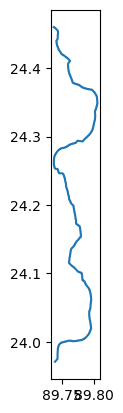

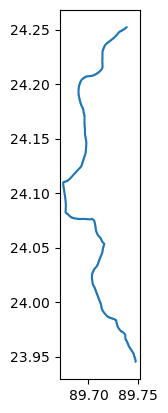

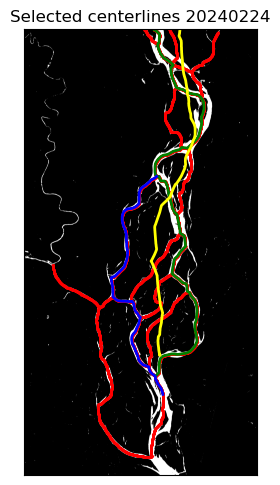

Runnning slope analysis for: 20241010
Closest mask date: 1024
Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


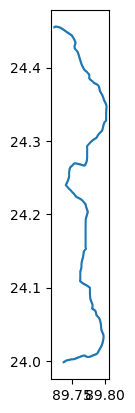

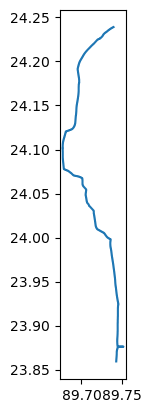

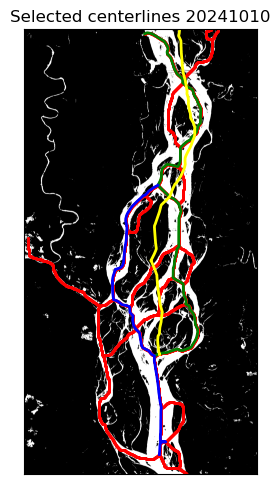

In [ ]:
# Just get ch centerlines! Plotting

### ---------------------------- Now, load in all centerlines and save individual images of 1. generated centerlines with and without label (same fig view), 2. SWOT projection onto new joint centerline, slope computed
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*") # Need to download 1 year of data for this tile! 


# Need to do still:  

pixc_filenames = [
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_011_258_112L_20240224T014502_20240224T014513_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc']



LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

# Pre-selected channels
channel1_dict = dict({'0124':['2','3','5','7','8','11','13','15','17','19'],
                      '0224':['2','3','6','10','11','12','16','19','21','22','24','26'], # this one may need ch 13
                      '0324':['1','3','5','10','11','12','15','18','20','21','23','25'], # this one may need ch 13
                      '0424':['1','2','4','9','10','11','12','15','16','18','20','24','27'],
                      '0524':['2','6','8','9','10','11','14','16','18','21','25','27'], # large gap
                      '0924':['3','5','6','7','10','13','15','18','22','28'],
                      '1024':['3','5','6','7','8','11','14','17','20','24'],
                      '1223':['4','5','8','11','12','13','16','17','20','24','27']}) # large gap
channel2_dict = dict({'0124':['10','12','21','22','25','26','27'], # large gap
                      '0224':['15','18','28','29','32','33','32'],
                      '0324':['16','17','27','28','31','32','33','34'], # large gap
                      '0424':['14','17','25','29','30','33','35','36','37'],
                      '0524':['13','17','30','29','31','35','37','38','40','42'],
                      '0924':['11','14','24','25','31','33','35'],
                      '1024':['10','12','15','22','27','30','31','34','36'],
                      '1223':['15','25','29','30','33','35','36','38','39']})


# Load in centerlines
for filename in pixc_filenames:

    pixcdate = os.path.basename(filename)[29:37]
    print('Runnning slope analysis for:',str(pixcdate))

    # Find mask date
    maskdate = pixcdate[4:6]+pixcdate[2:4]
    water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")

     # Need to find next closest mask in the same season...
    if not water_mask_tiff:
        currentmonth = pixcdate[4:6]
        if int(currentmonth) in LFmonths:
            season_months = LFmonths
        else:
            season_months = HFmonths


        dist = np.abs(np.array(season_months) - int(currentmonth))
        for j in np.unique(dist):
            if dist[dist == j][0] == 0: # skip if comparing with self
                continue
            if len(dist[dist == j]) > 1:
                # check first closest month
                monthid_indist = np.where(dist == j)[0][0]
                nextmonth = season_months[monthid_indist]
                if nextmonth < 10:
                    nextmonth = '0'+str(nextmonth)
                else:
                    nextmonth = str(nextmonth)

                maskdate = nextmonth+pixcdate[2:4]
                water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
                if water_mask_tiff:
                    break

                # check second closest month
                monthid_indist = np.where(dist == j)[0][1]
                nextmonth = season_months[monthid_indist]
                if nextmonth < 10:
                    nextmonth = '0'+str(nextmonth)
                else:
                    nextmonth = str(nextmonth)

                maskdate = nextmonth+pixcdate[2:4]
                water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
                if water_mask_tiff:
                    break

            else:
                monthid_indist = np.where(dist == j)[0][0]
                nextmonth = season_months[monthid_indist]
                if nextmonth < 10:
                    nextmonth = '0'+str(nextmonth)
                else:
                    nextmonth = str(nextmonth)

                maskdate = nextmonth+pixcdate[2:4]
                water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
                if water_mask_tiff:
                    break

    print('Closest mask date:',str(maskdate))
    water_mask_tiff = water_mask_tiff[0]
    #water_mask = skel.get_watermask(water_mask_tiff)

    cl_gen = gpd.read_file(odir+maskdate+'_generated_cl.geojson')
    cl_gen = cl_gen.to_crs('EPSG:4326') 
    sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

    ch1 = channel1_dict[maskdate]
    ch2 = channel2_dict[maskdate]

    ch1 = list(map(int, ch1))
    ch2 = list(map(int, ch2))

    branch_colors = ['green','blue']

    ## ------------------- Extract centerlines for joint branches and project SWOT pixc data 
    for i in range(2):
        if i == 0:
            selChannels_list = ch1
        if i == 1:
            selChannels_list = ch2

        selChannels = selChannels_list #list(map(int, selChannels_list))

        print('Extracting centerline from cl gdf... (merging and sorting)')
        # get connected CL
        idb = cl_gen['branch_id'].isin(selChannels_list)
        sel_cl = cl_gen.loc[idb]

        # Fill any gaps in selected centerline and sort reaches by branch id
        sel_cl = sel_cl.reset_index(drop=True)
        merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
        if isinstance(merged_parts,LineString):
            merged_line = merged_parts
        else:
            merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

        merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)
        merged_line_gdf.plot()
        sorted_gdf = merged_line_gdf
    

    ## ------------------- PLOT selected cl


    water_mask = skel.get_watermask(water_mask_tiff)
    fig, ax = plt.subplots(figsize=(3, 6))

    # water mask
    ax.imshow(water_mask, cmap=plt.cm.gray)
    # entire skeleton
    coords_df = cl_gen.get_coordinates()
    cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
    ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
    # for _, row in cl_gen.iterrows():
    #     ax.plot(*row.geometry.xy, color='red', linewidth=2)

    for i in range(2):
        if i == 0:
            selChannels_list = ch1
        if i == 1:
            selChannels_list = ch2

        selChannels = selChannels_list 

        print('Extracting centerline from cl gdf... (merging and sorting)')
        # get connected CL
        idb = cl_gen['branch_id'].isin(selChannels_list)
        sel_cl = cl_gen.loc[idb]

        # Fill any gaps in selected centerline and sort reaches by branch id
        sel_cl = sel_cl.reset_index(drop=True)
        merged_parts = skel.fill_cl_gaps(sel_cl,hemi,distance_threshold = 1000) # merge all main line parts
        if isinstance(merged_parts,LineString):
            merged_line = merged_parts
        else:
            merged_line = skel.merge_multiline_with_gaps(merged_parts)   # turns final multilinestring into single linestring and bridges any large gaps between parts

        merged_line_gdf = gpd.GeoDataFrame(geometry=[merged_line],crs=sel_cl.crs)    

        # get line in  pixel coords
        coords_df = merged_line_gdf.get_coordinates()
        merged_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)

        # for _, row in merged_line_gdf.iterrows():
        #     ax.plot(*row.geometry.xy, color=branch_colors[int(i)], linewidth=2)

        # selected channels
        ax.plot(merged_pixel_coords.x,merged_pixel_coords.y,color=branch_colors[int(i)],linewidth=2)


    # SWORD CL
    coords_df = sword_cl_gdf.get_coordinates()
    sword_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
    ax.plot(sword_pixel_coords.x,sword_pixel_coords.y,color='yellow',linewidth=2)

    y, x = np.where((water_mask)) 
    min_x, max_x = x.min(), x.max()
    min_y, max_y = y.min(), y.max()
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(max_y, min_y)

    # Set plot properties
    ax.set_title("Selected centerlines "+str(pixcdate))
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.savefig(figdir+'/'+str(pixcdate)+'_selectedChannels_w_mask.png')
    plt.show()



In [54]:
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*") # Need to download 1 year of data for this tile! 
pixc_filenames

['/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_018_258_112L_20240719T030033_20240719T030044_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_021_258_112L_20240919T171548_20240919T171559_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_020_258_112L_20240829T203042_20240829T203053_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_019_258_112L_20240808T234537_20240808T234548_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_017_258_112L_20240628T061528_20240628T061539_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_016_258_112L_20240607T093025_20240607T093036_PIC0_01.nc',
 '/Volumes/OneTouch/work

['0123', '0223', '0323', '0423', '0523', '0623', '0923', '1023', '1123', '1223', '0124', '0224', '0324', '0424', '0524', '0924', '1024']
Closest mask date: 0424
idsorted: 13


PLOTTING PRIOR MASK: 0324
PLOTTING PRIOR MASK: 0224
PLOTTING PRIOR MASK: 0124
PLOTTING PRIOR MASK: 1223


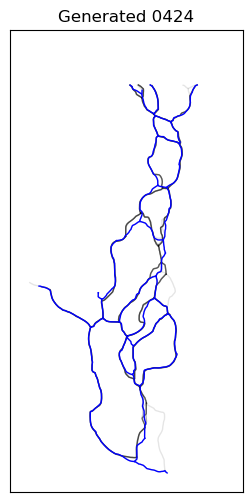

In [63]:
# PLOTTING CENTERLINES WITH DECREASING OPACITY



### ---------------------------- Now, load in all centerlines and save individual images of 1. generated centerlines with and without label (same fig view), 2. SWOT projection onto new joint centerline, slope computed
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*") # Need to download 1 year of data for this tile! 


# Need to do still:  

pixc_filenames = [
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_011_258_112L_20240224T014502_20240224T014513_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc']



LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

# Pre-selected channels
channel1_dict = dict({'0124':['2','3','5','7','8','11','13','15','17','19'],
                      '0224':['2','3','6','10','11','12','16','19','21','22','24','26'], # this one may need ch 13
                      '0324':['1','3','5','10','11','12','15','18','20','21','23','25'], # this one may need ch 13
                      '0424':['1','2','4','9','10','11','12','15','16','18','20','24','27'],
                      '0524':['2','6','8','9','10','11','14','16','18','21','25','27'], # large gap
                      '0924':['3','5','6','7','10','13','15','18','22','28'],
                      '1024':['3','5','6','7','8','11','14','17','20','24'],
                      '1223':['4','5','8','11','12','13','16','17','20','24','27']}) # large gap
channel2_dict = dict({'0124':['10','12','21','22','25','26','27'], # large gap
                      '0224':['15','18','28','29','32','33','32'],
                      '0324':['16','17','27','28','31','32','33','34'], # large gap
                      '0424':['14','17','25','29','30','33','35','36','37'],
                      '0524':['13','17','30','29','31','35','37','38','40','42'],
                      '0924':['11','14','24','25','31','33','35'],
                      '1024':['10','12','15','22','27','30','31','34','36'],
                      '1223':['15','25','29','30','33','35','36','38','39']})


pixcdate = '20240426'

# Get list of all mask dates
maskdates = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2_WaterMask_NDWI_****.tif")
maskdates = [os.path.basename(mask)[18:22] for mask in maskdates]
maskdates_list = [ date for date in maskdates if date.isnumeric() ]
sorted_dates = sorted(maskdates_list, key=lambda x: (int(x[2:]), int(x[:2])))

print(sorted_dates)

# Find mask date
maskdate = pixcdate[4:6]+pixcdate[2:4]
water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")

    # Need to find next closest mask in the same season...
if not water_mask_tiff:
    currentmonth = pixcdate[4:6]
    if int(currentmonth) in LFmonths:
        season_months = LFmonths
    else:
        season_months = HFmonths


    dist = np.abs(np.array(season_months) - int(currentmonth))
    for j in np.unique(dist):
        if dist[dist == j][0] == 0: # skip if comparing with self
            continue
        if len(dist[dist == j]) > 1:
            # check first closest month
            monthid_indist = np.where(dist == j)[0][0]
            nextmonth = season_months[monthid_indist]
            if nextmonth < 10:
                nextmonth = '0'+str(nextmonth)
            else:
                nextmonth = str(nextmonth)

            maskdate = nextmonth+pixcdate[2:4]
            water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
            if water_mask_tiff:
                break

            # check second closest month
            monthid_indist = np.where(dist == j)[0][1]
            nextmonth = season_months[monthid_indist]
            if nextmonth < 10:
                nextmonth = '0'+str(nextmonth)
            else:
                nextmonth = str(nextmonth)

            maskdate = nextmonth+pixcdate[2:4]
            water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
            if water_mask_tiff:
                break

        else:
            monthid_indist = np.where(dist == j)[0][0]
            nextmonth = season_months[monthid_indist]
            if nextmonth < 10:
                nextmonth = '0'+str(nextmonth)
            else:
                nextmonth = str(nextmonth)

            maskdate = nextmonth+pixcdate[2:4]
            water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
            if water_mask_tiff:
                break

print('Closest mask date:',str(maskdate))
water_mask_tiff = water_mask_tiff[0]
idsorted = sorted_dates.index(maskdate)
print('idsorted:',idsorted)


#water_mask = skel.get_watermask(water_mask_tiff)

cl_gen = gpd.read_file(odir+maskdate+'_generated_cl.geojson')
cl_gen = cl_gen.to_crs('EPSG:4326') 
sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

ch1 = channel1_dict[maskdate]
ch2 = channel2_dict[maskdate]

ch1 = list(map(int, ch1))
ch2 = list(map(int, ch2))

branch_colors = ['green','blue']

# find two previous mask cls
fig, ax = plt.subplots(figsize=(3, 6))
alpha_vals = [0.5,0.3,0.2,0.1]

for i in range(4):

    id_prev = idsorted - (i+1)
    prior_mask_date = sorted_dates[id_prev]
    print('PLOTTING PRIOR MASK:',prior_mask_date)
    prev_cl = gpd.read_file(odir+prior_mask_date+'_generated_cl.geojson')
    prev_cl.to_crs('EPSG:4326')

    # Plot 
    for _, row in prev_cl.iterrows():
        ax.plot(*row.geometry.xy, color='black', linewidth=1,alpha=alpha_vals[i])

for _, row in cl_gen.iterrows():
    ax.plot(*row.geometry.xy, color='blue', linewidth=1)

# Set plot properties
ax.set_title("Generated "+str(maskdate))
ax.axis("equal")
# Remove x and y tick marks
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(89.575,89.855)
ax.set_ylim(23.8,24.55)
plt.show()





In [17]:
np.ceil(medY)
np.floor(medY)
np.round(9.5,0)


10.0

LINESTRING (89.72117037929807 24.46045145011148, 89.72126021082647 24.460361618583065, 89.72135004235489 24.46027178705465, 89.7214398738833 24.46018195552624, 89.72152970541171 24.460092123997825, 89.72161953694012 24.460092123997832, 89.72170936846854 24.46000229246941, 89.72179919999695 24.459912460941005, 89.72188903152536 24.459822629412585, 89.72197886305376 24.45982262941259, 89.72206869458218 24.45973279788418, 89.72215852611059 24.459642966355773, 89.72224835763902 24.459553134827363, 89.72233818916742 24.459553134827363, 89.72242802069583 24.459463303298943, 89.72251785222424 24.459373471770537, 89.72260768375266 24.459373471770533, 89.72269751528107 24.45928364024212, 89.72278734680948 24.459193808713714, 89.7228771783379 24.45919380871371, 89.72296700986631 24.459103977185297, 89.72305684139471 24.459014145656884, 89.72314667292312 24.459014145656887, 89.72323650445153 24.458924314128478, 89.72332633597996 24.45883448260006, 89.72341616750836 24.45883448260006, 89.723505999

In [ ]:
### Run through all skeletons and plot skeleton overtop of water mask


Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
Extracting centerline from cl gdf... (merging and sorting)
Projecting SWOT PIXC to joint centerline...
Projected!
CH. 1 slope = -3.5517 cm/km
CH. 2 slope = -5.8084 cm/km


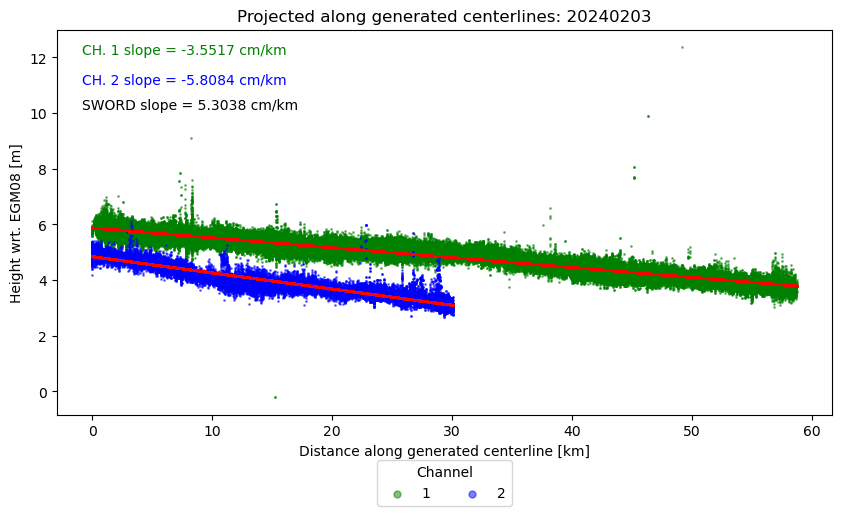

CH. 1 slope = 4.7305 cm/km
CH. 2 slope = 7.8244 cm/km


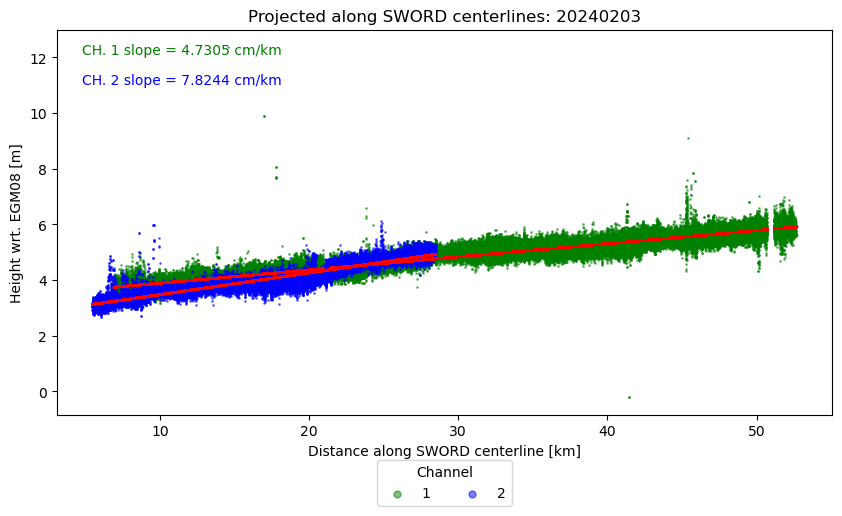

Extracting centerline from cl gdf... (merging and sorting)
Extracting centerline from cl gdf... (merging and sorting)


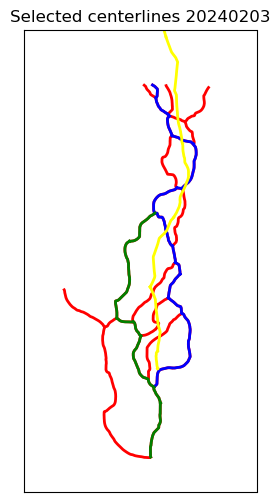

In [ ]:
#### OLD - viewing one selected ch

ch1 = ['2','3','6','10','11','12','15','17','19','20','22','24']
ch2 = ['14','16','26','27','30','31','32']
ch1 = list(map(int, ch1))
ch2 = list(map(int, ch2))

branch_colors = ['green','blue']

swot_pixc['joint_channel_id'] = 0
swot_pixc['dist_jointChannel'] = 0

## ------------------- Extract centerlines for joint branches and project SWOT pixc data 
for i in range(2):
    if i == 0:
        selChannels_list = ch1
    if i == 1:
        selChannels_list = ch2

    

    selChannels = selChannels_list #list(map(int, selChannels_list))

    print('Extracting centerline from cl gdf... (merging and sorting)')
    # get connected CL
    idb = cl_gen['branch_id'].isin(selChannels_list)
    sel_cl = cl_gen.loc[idb]

    # Fill any gaps in selected centerline and sort reaches
    merged_gdf = fill_cl_gaps(sel_cl,hemi)
    sorted_gdf, line_sorted = sort_general_cl(merged_gdf,showPlots=False,reverse=True) # Does this need to be a single line?


    print('Projecting SWOT PIXC to joint centerline...')
    # Select all PIXC data associated with these channels and plot projected to CL
    idx = swot_pixc['channelID'].isin(selChannels_list)
    swot_pixc.loc[idx, 'joint_channel_id'] = i + 1

    swot_pixc.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(sorted_gdf,swot_pixc.loc[idx,['geometry']],hemi)
    print('Projected!')


## ------------------- Project against SWORD
swot_pixc['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_points,swot_pixc[['geometry']],hemi)
regr_sword = LinearRegression()
regr_sword.fit(swot_pixc[['dist_SWORDcl']], swot_pixc[['heightEGM']])
h_pred_sword = regr_sword.predict(swot_pixc[['dist_SWORDcl']])

## ------------------- PLOT against generated centerline
slopes = []
fig, ax = plt.subplots(figsize=(10, 5))
for joint_channel in np.unique(swot_pixc['joint_channel_id']):
    if joint_channel == 0:
        continue
    channels_gdf = swot_pixc[swot_pixc['joint_channel_id'] == joint_channel]
    regr = LinearRegression()
    regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM']])
    h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
    print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
    slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
    ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM'], alpha=0.5, c=branch_colors[int(joint_channel-1)], s=1.0, label=str(int(joint_channel)))
    ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')

ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=2, markerscale=5)
ax.set_xlabel("Distance along generated centerline [km]")
ax.set_ylabel("Height wrt. EGM08 [m]")
ax.set_title('Projected along generated centerlines: '+str(pixcdate))
plt.figtext(0.15, 0.83, f'CH. 1 slope = {slopes[0]} cm/km',color=branch_colors[0])
plt.figtext(0.15, 0.77, f'CH. 2 slope = {slopes[1]} cm/km',color=branch_colors[1])
plt.figtext(0.15, 0.72, f'SWORD slope = {np.round(regr_sword.coef_[0][0]*1000*100,decimals=4)} cm/km',color='black')
plt.savefig(figdir+'/'+str(pixcdate)+'_projected2jointCL.png')
plt.show()


## ------------------- PLOT against SWORD
slopes = []
fig, ax = plt.subplots(figsize=(10, 5))
for joint_channel in np.unique(swot_pixc['joint_channel_id']):
    if joint_channel == 0:
        continue
    channels_gdf = swot_pixc[swot_pixc['joint_channel_id'] == joint_channel]
    regr = LinearRegression()
    regr.fit(channels_gdf[['dist_SWORDcl']], channels_gdf[['heightEGM']])
    h_pred = regr.predict(channels_gdf[['dist_SWORDcl']])
    print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
    slopes.append(np.round(regr.coef_[0][0]*1000*100,decimals=4))
    ax.scatter(channels_gdf['dist_SWORDcl']/1000, channels_gdf['heightEGM'], alpha=0.5, c=branch_colors[int(joint_channel-1)], s=1.0, label=str(int(joint_channel)))
    ax.plot(channels_gdf.dist_SWORDcl/1000, h_pred,'.',markersize=1,c='red')


ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=2, markerscale=5)
ax.set_xlabel("Distance along SWORD centerline [km]")
ax.set_ylabel("Height wrt. EGM08 [m]")
ax.set_title('Projected along SWORD centerlines: '+str(pixcdate))
plt.figtext(0.15, 0.83, f'CH. 1 slope = {slopes[0]} cm/km',color=branch_colors[0])
plt.figtext(0.15, 0.77, f'CH. 2 slope = {slopes[1]} cm/km',color=branch_colors[1])
plt.savefig(figdir+'/'+str(pixcdate)+'_projected2SWORD.png')
plt.show()


## ------------------- PLOT selected cl

fig, ax = plt.subplots(figsize=(3, 6))
for _, row in cl_gen.iterrows():
    ax.plot(*row.geometry.xy, color='red', linewidth=2)

for i in range(2):
    if i == 0:
        selChannels_list = ch1
    if i == 1:
        selChannels_list = ch2

    selChannels = selChannels_list 

    print('Extracting centerline from cl gdf... (merging and sorting)')
    # get connected CL
    idb = cl_gen['branch_id'].isin(selChannels_list)
    sel_cl = cl_gen.loc[idb]

    # Fill any gaps in selected centerline and sort reaches
    merged_gdf = fill_cl_gaps(sel_cl,hemi)
    sorted_gdf, line_sorted = sort_general_cl(merged_gdf,showPlots=False,reverse=True) 

    for _, row in sorted_gdf.iterrows():
        ax.plot(*row.geometry.xy, color=branch_colors[int(i)], linewidth=2)

for _, row in sword_cl_gdf.iterrows():
    ax.plot(*row.geometry.xy, color='yellow', linewidth=2)

# Set plot properties
ax.set_title("Selected centerlines "+str(pixcdate))
ax.axis("equal")
# Remove x and y tick marks
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(89.575,89.855)
ax.set_ylim(23.8,24.55)
plt.savefig(figdir+'/'+str(pixcdate)+'_projected2SWORD.png')




In [ ]:
# TUNING DILATION AND GAUSSIAN SMOOTHING PARAMETERS! 
#filename =  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc' #HF
filename = "/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc" #LF


LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

pixcdate = os.path.basename(filename)[29:37]
print('Runnning braided river analysis for:',str(pixcdate))

maskdate = pixcdate[4:6]+pixcdate[2:4]
water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")

lastmonth = pixcdate[4:6]
while not water_mask_tiff:
    nextmonth = int(lastmonth) - 1
    if nextmonth < 10:
        nextmonth = '0'+str(nextmonth)
    else:
        nextmonth = str(nextmonth)
    maskdate = nextmonth+pixcdate[2:4]
    water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
    lastmonth = nextmonth

print('Closest mask date:',str(maskdate))
water_mask_tiff = water_mask_tiff[0]
print(water_mask_tiff)

dilation_var = [10,20,20]
gaussian_var = [10,20,30]
for dilate in dilation_var:
    for gauss in gaussian_var:

        print('dilation amount: ',dilate)
        print('gaussian filter amount: ',gauss)

        print('Proceed with operation skeleton...')
        water_mask = skel.get_watermask(water_mask_tiff)
        skeleton = skel.get_skeleton(water_mask,pixcdate,figdir,dilate,gauss,savePlot=True)
        pruned_skeleton = skel.get_pruned_skeleton(skeleton, water_mask,pixcdate,figdir,prunethresh=600)
        #labeled_skeleton = skel.get_labeled_skeleton(pruned_skeleton,pixcdate,figdir,savePlot=True)
        #gen_cl = skel.extract_cl_from_skeleton(labeled_skeleton,water_mask_tiff)
        #gen_cl.plot()


NameError: name 'os' is not defined

...........Running get skeleton algorithm...........
...........Running branch pruning algorithm...........
Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!


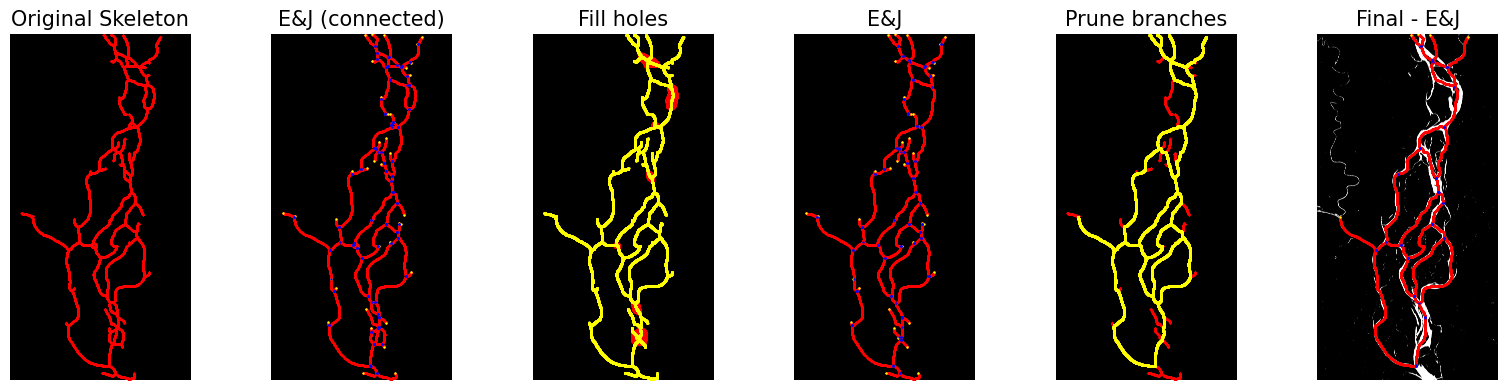

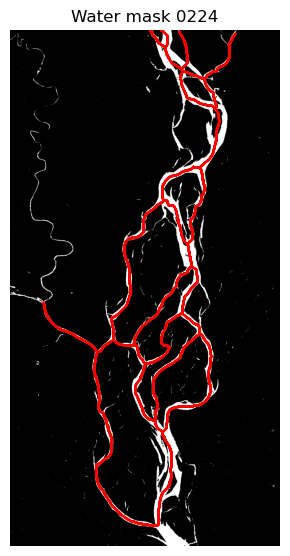

In [ ]:
### ............ RUNNNING EXPERIMENTS (order of dilating, smoothing, pruning)
# LF: try 2024-01-13
# HF: try 2024-07-19

pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*20240719*") # Need to download 1 year of data for this tile! 
filename = pixc_filenames[0]
print(filename)


runNewCL = False

LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

pixcdate = os.path.basename(filename)[29:37]
print('Runnning braided river analysis for:',str(pixcdate))

maskdate = pixcdate[4:6]+pixcdate[2:4]
water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")


    # Need to find next closest mask in the same season...
if not water_mask_tiff:
    currentmonth = pixcdate[4:6]
    if int(currentmonth) in LFmonths:
        season_months = LFmonths
    else:
        season_months = HFmonths


    dist = np.abs(np.array(season_months) - int(currentmonth))
    for j in np.unique(dist):
        if dist[dist == j][0] == 0: # skip if comparing with self
            continue
        if len(dist[dist == j]) > 1:
            # check first closest month
            monthid_indist = np.where(dist == j)[0][0]
            nextmonth = season_months[monthid_indist]
            if nextmonth < 10:
                nextmonth = '0'+str(nextmonth)
            else:
                nextmonth = str(nextmonth)

            maskdate = nextmonth+pixcdate[2:4]
            water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
            if water_mask_tiff:
                break

            # check second closest month
            monthid_indist = np.where(dist == j)[0][1]
            nextmonth = season_months[monthid_indist]
            if nextmonth < 10:
                nextmonth = '0'+str(nextmonth)
            else:
                nextmonth = str(nextmonth)

            maskdate = nextmonth+pixcdate[2:4]
            water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
            if water_mask_tiff:
                break

        else:
            monthid_indist = np.where(dist == j)[0][0]
            nextmonth = season_months[monthid_indist]
            if nextmonth < 10:
                nextmonth = '0'+str(nextmonth)
            else:
                nextmonth = str(nextmonth)

            maskdate = nextmonth+pixcdate[2:4]
            water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/S2*"+str(maskdate)+".tif")
            if water_mask_tiff:
                break

print('Closest mask date:',str(maskdate))
water_mask_tiff = water_mask_tiff[0]

# Get season
if int(maskdate[0:2]) in LFmonths:
    #season = 'LF'
    dilate = 10
    gauss = 20
else:
    #season = 'HF'
    dilate = 10
    gauss = 30

# Proceed with operation skeleton
print('Proceed with operation skeleton...')

# FIRST Check if a centerline has already been created for this mask....
if os.path.exists(odir+maskdate+'_generated_cl.geojson') and runNewCL == False:
    print('Mask centerline already processed!')
    gen_cl = gpd.read_file(odir+maskdate+'_generated_cl.geojson')
else:
    water_mask = skel.get_watermask(water_mask_tiff)


    skeleton = skel.get_skeleton(water_mask,pixcdate,figdir,dilate,gauss,savePlot=True)
    # for exp_number in [1,3,5]:
    #     print('RUNING EXPERIMENT NO. ',exp_number)
    #     if exp_number == 5:
    #         hs = 100
    #     else:
    #         hs = 400
    #     skeleton = skel.experiment_get_and_prune_skeleton(exp_number,water_mask,dilate,gauss,distance_threshold=100,max_hole_size=hs,prunethresh=600)
    #skeleton,mask_image,pixcdate,figdir,distance_threshold=30,max_hole_size=300,prunethresh=600
    pruned_skeleton = skel.get_pruned_skeleton(skeleton, water_mask, pixcdate,figdir,distance_threshold=100,max_hole_size=300,prunethresh=600) # distance thresh for connecting pixels
    labeled_skeleton = skel.get_labeled_skeleton(pruned_skeleton,pixcdate,figdir,savePlot=True)
    gen_cl = skel.extract_cl_from_skeleton(labeled_skeleton,water_mask_tiff)
    cl_merged = skel.merge_short_centerlines(gen_cl,hemi)
    skel.plot_merged(cl_merged,maskdate,figdir)


In [ ]:
# OLD functions.....


def merge_short_centerlines_with_direction(gen_cl,hemi): ### OLD!
    # Merges centerlines with branch length < 2000 m based on their direction

    # INPUTS:
    #   - gen_cl : the generated centerlines from the water mask raster 
    #               type = <class 'geopandas.geodataframe.GeoDataFrame'
    #               gen_cl contains fields of 'branch_id' = unique integer branch id
    #                                           'gemetry' = LineString geometry of the branch
    #   - hemi : string of 'north' if in the northern hemisphere, 'south' if in the southern
    # 

    # get utm crs
    centroid = gen_cl.geometry.unary_union.centroid
    utm_zone = int((centroid.x + 180) // 6) + 1  # Calculate UTM zone
    if hemi == 'north':
        utm_crs = f'EPSG:{32600 + utm_zone}'
    if hemi == 'south':
        utm_crs = f'EPSG:{32700 + utm_zone}'


    cl_utm = gen_cl.to_crs(utm_crs)
    cl_utm['length'] = cl_utm.length

    # Identify linestrings with branch length < 2 km
    short_branches = cl_utm[cl_utm['length'] < 2000]
    short_branches_list = list(short_branches.branch_id)
    # Save all other branches 
    print('short branch list:',short_branches_list)
    cl_new = cl_utm[cl_utm['length'] >= 2000]

    # Loop through all branches in the short branch list!
    imax = len(short_branches_list)
    for i in range(len(short_branches_list)):
        
        if i == imax:
            break
        # print('i',i)
        # print('short_branches_list',short_branches_list)
        branch_id = short_branches_list[i]
        print('len short branch list:',len(short_branches_list))
        print('branch',branch_id)
        branch_gdf = cl_utm[cl_utm.branch_id == branch_id]
        branch_geom = branch_gdf.geometry.iloc[0]

        # branch_endpoints_list = [ tuple(branch_geom.coords[0]),  # Start point
        #         tuple(branch_geom.coords[-1]) ]  # End point]
        
        branch_endpoints = [
            (tuple(branch_geom.coords[0]), calculate_vector(branch_geom, 0)),  # Start
            (tuple(branch_geom.coords[-1]), calculate_vector(branch_geom, -1)),  # End
        ]

        # branch_endpoints_vector = [calculate_vector(branch_geom, 0), calculate_vector(branch_geom, -1)]

        closest_branch = None
        min_distance = float('inf')
        max_similarity = -1
        highest_similarity = -1
        min_similarity = 0.7

        connection_threshold = 500  # threshold distance to be considered for the similarity test
        # Search all other endpoints (all other geometries) for the closest endpoint
        for bid in cl_utm.branch_id:

            candidate_gdf = cl_utm[cl_utm.branch_id == bid] # GDF
            candidate_geom = candidate_gdf.geometry.iloc[0] # SHAPELY LINESTRING
            # candidate_endpoints_list = [ tuple(candidate_geom.coords[0]),  
            #     tuple(candidate_geom.coords[-1]) ]  # LIST
            
            candidate_endpoints = [
                (tuple(candidate_geom.coords[0]), calculate_vector(candidate_geom, 0)),
                (tuple(candidate_geom.coords[-1]), calculate_vector(candidate_geom, -1)),
            ]


            if branch_geom.equals(candidate_geom):
                continue

            for endpoint, branch_vector in branch_endpoints: 
                # ENDPOINT == TUPLE
                # ENDPOINT[0] == FLOAT
                # BRANCH_VECTOR = NUMPY ARRAY
                # print('endpoint:',endpoint)
                # print('type:',type(endpoint))
                # print('type:',type(endpoint[0]))

                # print('branch_vector',branch_vector)
                # print('type:',type(branch_vector))
                for candidate_endpoint, candidate_vector in candidate_endpoints:
                    
                    distance = Point(endpoint).distance(Point(candidate_endpoint)) # FLOAT
                    similarity = cosine_similarity(branch_vector.reshape(1, -1), candidate_vector.reshape(1, -1))

                    if distance < connection_threshold and similarity > highest_similarity:
                        highest_similarity = similarity
                        highest_sim_branch = bid

                    if distance < connection_threshold and similarity > max_similarity and similarity > min_similarity:
                        #min_distance = distance
                        max_similarity = similarity
                        closest_branch_id = bid #INT
                        # print('MAX SIM:')
                        # print(similarity)
                        print('Connecting branch '+str(branch_id)+' with branch '+str(closest_branch_id))


                        short_connection = int(endpoint != branch_endpoints[0][0]) # RETURN 0 IF SHORT BRANCH IS CONNECTED BY ITS START, 1 IF CONNECTED BY ITS END (INT)
                        long_connection = int(candidate_endpoint != candidate_endpoints[0][0]) # RETURN 0 IF LONG (CANDIDATE) BRANCH IS CONNECTED BY ITS START, 1 IF CONNECTED BY ITS END (INT)
            
        if max_similarity == -1:
            # Never entered the previous check, then we need to add the current branch back to the shapefile (no merging -- does not belong to a joining branch) 
            cl_new = pd.concat([cl_new, branch_gdf])
            print('no branch with high enough similarity for bid:',branch_id)
            print('highest_similarity: ',highest_similarity,' with branch:',highest_sim_branch)

            #print(branch_gdf)
            continue # Continue to next short branch


        if max_similarity != -1:
            # Now, with this information, merge the closest branch and save to cl gdf
            # Here, need to extarct the most updated branch....
            closest_branch_gdf = cl_utm.loc[cl_utm['branch_id'] == closest_branch_id]

            # put coordinates of both into one df
            if short_connection == 0 and long_connection == 0:
                all_df = pd.concat([closest_branch_gdf.get_coordinates().iloc[::-1],branch_gdf.get_coordinates()])
            if short_connection == 1 and long_connection == 0:
                all_df = pd.concat([branch_gdf.get_coordinates(),closest_branch_gdf.get_coordinates()])
            if short_connection == 1 and long_connection == 1:
                all_df = pd.concat([closest_branch_gdf.get_coordinates(),branch_gdf.get_coordinates().iloc[::-1]])
            if short_connection == 0 and long_connection == 1:
                all_df = pd.concat([closest_branch_gdf.get_coordinates(),branch_gdf.get_coordinates()])

            # Convert to gdf and add to cl_new
            all_coords = list(zip(all_df.x, all_df.y))
            # Merge branches
            line = LineString(all_coords)
            cl_df_temp = gpd.GeoDataFrame(geometry=[line],crs=utm_crs)
            cl_df_temp['branch_id'] = closest_branch_id
            cl_df_temp['length'] = cl_df_temp.length
            print('new length:',cl_df_temp.length[0])
            print('new branch id:',cl_df_temp['branch_id'].iloc[0])

            # If new merged branch id already exists in cl_new, remove it first!
            if cl_new.loc[(cl_new['branch_id'] == closest_branch_id)].any().all():
                print('drop old id:',closest_branch_id)
                cl_new = cl_new.drop(cl_new[cl_new['branch_id'] == closest_branch_id].index)


            cl_new = pd.concat([cl_new,cl_df_temp])
            print('added branch ',cl_new.loc[(cl_new['branch_id']==closest_branch_id)])
            print('added branch length',cl_new.loc[(cl_new['branch_id']==closest_branch_id)].length)
            print(cl_new)
            if closest_branch_id in short_branches_list and cl_df_temp.length.iloc[0] > 2000:
                    if closest_branch_id == short_branches_list[-1]:

                        short_branches_list.remove(closest_branch_id)
                        #print('updated short branch list:',short_branches_list)
                        break
                    else:
                        short_branches_list.remove(closest_branch_id)
                        #print('updated short branch list:',short_branches_list)
                        imax = imax - 1

                    # print('removing branch:',closest_branch_id)
                    # print('...new list:',short_branches_list)

    # Order cl_new and rename branches
    print(cl_new)

    cl_new  = cl_new.sort_values(by=['branch_id'])
    cl_new = cl_new.to_crs('EPSG:4326')
    cl_new = cl_new.reset_index(drop=True)
    cl_new['branch_id_old'] = cl_new['branch_id']
    cl_new['branch_id'] = cl_new.index + 1
    print(cl_new)
    # print(cl_new)
    return cl_new